Generate data for synthetic graph datasets, the graphs are generated with different shapes and features. For example circle, line, cross, star, grid, and the features are different, such as color, size, and charge. They are saved in the directory specified by the `output_dir` variable. Currently it will generate 2500 sample graphs, and also the png which shows the graphs. It will generate different colours. over all nodes of the graph. Naturally the properties for the amino etc are fake.
n_samples=100,
        min_nodes=8,
        max_nodes=20,
        shape_types=['circle', 'line', 'cross', 'star', 'grid'],
        feature_configs=feature_configs,
        output_dir='synthetic_graph_data'


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from sklearn.preprocessing import OneHotEncoder

# Set random seed for reproducibility
np.random.seed(42)

# Define amino acid types and their one-hot encoding
AMINO_TYPES = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
               'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

# Create one-hot encoder for amino types
# In newer scikit-learn versions, use sparse_output instead of sparse
try:
    # For newer scikit-learn versions (>=1.2)
    amino_encoder = OneHotEncoder(sparse_output=False)
except TypeError:
    # For older scikit-learn versions
    amino_encoder = OneHotEncoder(sparse=False)
amino_encoder.fit(np.array(AMINO_TYPES).reshape(-1, 1))

# Define colors for the color feature
COLORS = ['red', 'green', 'blue', 'yellow', 'purple']

# Define node sizes for the size feature
SIZES = [1, 2, 3, 4, 5]  # Normalized size values

# Define charge values
CHARGES = [-1.0, -0.5, 0.0, 0.5, 1.0]

# Define hydrophobicity values
HYDROPHOBICITY = [0.1, 0.3, 0.5, 0.7, 0.9]

# Define functions to generate different graph shapes
def generate_circle_graph(n_nodes, variance=0.1):
    """Generate a circular graph with slight variance."""
    G = nx.Graph()
    for i in range(n_nodes):
        angle = 2 * np.pi * i / n_nodes
        radius = 1.0 + np.random.normal(0, variance)
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        G.add_node(i, pos=(x, y))

    # Connect neighbors in the circle
    for i in range(n_nodes):
        G.add_edge(i, (i + 1) % n_nodes)

    return G

def generate_line_graph(n_nodes, variance=0.1):
    """Generate a straight line graph with slight variance."""
    G = nx.Graph()
    for i in range(n_nodes):
        x = 2 * i / (n_nodes - 1) - 1  # Scale to [-1, 1]
        y = np.random.normal(0, variance)
        G.add_node(i, pos=(x, y))

    # Connect neighbors in the line
    for i in range(n_nodes - 1):
        G.add_edge(i, i + 1)

    return G

def generate_cross_graph(n_nodes, variance=0.1):
    """Generate a cross-shaped graph."""
    G = nx.Graph()
    half = n_nodes // 2
    remainder = n_nodes - (2 * half)

    # Horizontal line
    for i in range(half):
        x = 2 * i / (half - 1) - 1  # Scale to [-1, 1]
        y = np.random.normal(0, variance)
        G.add_node(i, pos=(x, y))

    # Connect horizontal neighbors
    for i in range(half - 1):
        G.add_edge(i, i + 1)

    # Vertical line
    for i in range(half + remainder):
        idx = i + half
        x = np.random.normal(0, variance)
        y = 2 * i / (half + remainder - 1) - 1  # Scale to [-1, 1]
        G.add_node(idx, pos=(x, y))

    # Connect vertical neighbors
    for i in range(half, n_nodes - 1):
        G.add_edge(i, i + 1)

    # Connect the center of the cross
    mid_h = half // 2
    mid_v = half + (half + remainder) // 2
    G.add_edge(mid_h, mid_v)

    return G

def generate_star_graph(n_nodes, variance=0.1):
    """Generate a star-shaped graph."""
    G = nx.Graph()
    # Center node
    G.add_node(0, pos=(0, 0))

    # Outer nodes
    for i in range(1, n_nodes):
        angle = 2 * np.pi * (i - 1) / (n_nodes - 1)
        radius = 1.0 + np.random.normal(0, variance)
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        G.add_node(i, pos=(x, y))

        # Connect to center
        G.add_edge(0, i)

    return G

def generate_grid_graph(n_nodes, variance=0.1):
    """Generate a grid-like graph."""
    # Find the closest perfect square
    side = int(np.sqrt(n_nodes))
    if side * side < n_nodes:
        side += 1

    G = nx.Graph()
    node_idx = 0

    # Create grid positions
    for i in range(side):
        for j in range(side):
            if node_idx < n_nodes:
                x = (2 * j / (side - 1) - 1) + np.random.normal(0, variance) if side > 1 else 0
                y = (2 * i / (side - 1) - 1) + np.random.normal(0, variance) if side > 1 else 0
                G.add_node(node_idx, pos=(x, y))
                node_idx += 1

    # Add edges in grid pattern
    for i in range(n_nodes):
        row, col = i // side, i % side

        # Right neighbor
        if col < side - 1 and i + 1 < n_nodes:
            G.add_edge(i, i + 1)

        # Down neighbor
        if row < side - 1 and i + side < n_nodes:
            G.add_edge(i, i + side)

    return G

# Function to assign features to nodes
def assign_features(G, feature_config):
    """
    Assign node features based on configuration:
    - amino_type: Randomly assigned or all same type
    - color: All nodes get the same color
    - size: All nodes get the same size
    - charge: All nodes get the same charge
    - hydrophobicity: All nodes get the same hydrophobicity
    - x_coord: The x-coordinate position
    - y_coord: The y-coordinate position
    - degree: Node degree (connectivity)
    - clustering: Local clustering coefficient

    feature_config: dict with keys being feature names and values being either:
        - 'random': Assign random values
        - 'uniform': Assign the same random value to all nodes
        - specific value: Assign that value to all nodes
    """
    n_nodes = G.number_of_nodes()

    # Initialize feature dictionary
    features = {node: {} for node in G.nodes()}

    # Assign amino type (one-hot encoded)
    if 'amino_type' in feature_config:
        if feature_config['amino_type'] == 'random':
            amino_types = np.random.choice(AMINO_TYPES, size=n_nodes)
        elif feature_config['amino_type'] == 'uniform':
            amino_type = np.random.choice(AMINO_TYPES)
            amino_types = [amino_type] * n_nodes
        else:
            # Specific amino type
            if feature_config['amino_type'] in AMINO_TYPES:
                amino_types = [feature_config['amino_type']] * n_nodes
            else:
                amino_types = np.random.choice(AMINO_TYPES, size=n_nodes)

        # One-hot encode amino types
        encoded_aminos = amino_encoder.transform(np.array(amino_types).reshape(-1, 1))

        # Assign to nodes
        for i, node in enumerate(G.nodes()):
            for j, value in enumerate(encoded_aminos[i]):
                feature_name = f'amino_{AMINO_TYPES[j]}'
                # Handle the possibility of a sparse matrix return type
            if hasattr(value, 'toarray'):
                val = float(value.toarray()[0, 0])
            else:
                val = float(value)
            features[node][feature_name] = val
            features[node]['amino_raw'] = amino_types[i]

    # Assign color
    if 'color' in feature_config:
        if feature_config['color'] == 'random':
            colors = np.random.choice(COLORS, size=n_nodes)
        elif feature_config['color'] == 'uniform':
            color = np.random.choice(COLORS)
            colors = [color] * n_nodes
        else:
            # Specific color
            if feature_config['color'] in COLORS:
                colors = [feature_config['color']] * n_nodes
            else:
                colors = np.random.choice(COLORS, size=n_nodes)

        # One-hot encode colors
        for i, node in enumerate(G.nodes()):
            features[node]['color'] = colors[i]
            for c in COLORS:
                features[node][f'color_{c}'] = 1.0 if colors[i] == c else 0.0

    # Assign size
    if 'size' in feature_config:
        if feature_config['size'] == 'random':
            sizes = np.random.choice(SIZES, size=n_nodes)
        elif feature_config['size'] == 'uniform':
            size = np.random.choice(SIZES)
            sizes = [size] * n_nodes
        else:
            try:
                size_val = float(feature_config['size'])
                sizes = [size_val] * n_nodes
            except:
                sizes = np.random.choice(SIZES, size=n_nodes)

        for i, node in enumerate(G.nodes()):
            features[node]['size'] = float(sizes[i])

    # Assign charge
    if 'charge' in feature_config:
        if feature_config['charge'] == 'random':
            charges = np.random.choice(CHARGES, size=n_nodes)
        elif feature_config['charge'] == 'uniform':
            charge = np.random.choice(CHARGES)
            charges = [charge] * n_nodes
        else:
            try:
                charge_val = float(feature_config['charge'])
                charges = [charge_val] * n_nodes
            except:
                charges = np.random.choice(CHARGES, size=n_nodes)

        for i, node in enumerate(G.nodes()):
            features[node]['charge'] = float(charges[i])

    # Assign hydrophobicity
    if 'hydrophobicity' in feature_config:
        if feature_config['hydrophobicity'] == 'random':
            hydro_vals = np.random.choice(HYDROPHOBICITY, size=n_nodes)
        elif feature_config['hydrophobicity'] == 'uniform':
            hydro_val = np.random.choice(HYDROPHOBICITY)
            hydro_vals = [hydro_val] * n_nodes
        else:
            try:
                h_val = float(feature_config['hydrophobicity'])
                hydro_vals = [h_val] * n_nodes
            except:
                hydro_vals = np.random.choice(HYDROPHOBICITY, size=n_nodes)

        for i, node in enumerate(G.nodes()):
            features[node]['hydrophobicity'] = float(hydro_vals[i])

    # Add positional and structural features
    for node in G.nodes():
        # X and Y coordinates (normalized)
        if 'x_coord' in feature_config:
            features[node]['x_coord'] = float(G.nodes[node]['pos'][0])

        if 'y_coord' in feature_config:
            features[node]['y_coord'] = float(G.nodes[node]['pos'][1])

        # Node degree (connectivity)
        if 'degree' in feature_config:
            features[node]['degree'] = float(G.degree(node))

    # Clustering coefficient (local triangle density)
    if 'clustering' in feature_config:
        clustering = nx.clustering(G)
        for node in G.nodes():
            features[node]['clustering'] = float(clustering[node])

    # Update graph with features
    for node, node_features in features.items():
        nx.set_node_attributes(G, {node: node_features})

    return G

# Function to calculate edge distances
def calculate_edge_distances(G):
    """Calculate Euclidean distances for all edges."""
    for u, v in G.edges():
        pos_u = G.nodes[u]['pos']
        pos_v = G.nodes[v]['pos']
        distance = np.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)
        G[u][v]['distance'] = float(distance)

    return G

# Main function to generate graph datasets
def generate_graph_datasets(n_samples=5, min_nodes=8, max_nodes=20,
                            shape_types=['circle', 'line', 'cross', 'star', 'grid'],
                            feature_configs=None,
                            output_dir='graph_datasets'):
    """
    Generate synthetic graph datasets with different shapes and features.

    Parameters:
    - n_samples: Number of samples per shape and feature configuration
    - min_nodes, max_nodes: Range for number of nodes
    - shape_types: List of graph shapes to generate
    - feature_configs: List of feature configurations to apply
    - output_dir: Directory to save the generated graphs
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Default feature configurations if none provided
    if feature_configs is None:
        feature_configs = [
            {
                'name': 'red_amino_ala',
                'amino_type': 'ALA',
                'color': 'red',
                'size': 3,
                'charge': 0.0,
                'hydrophobicity': 0.5,
                'x_coord': True,
                'y_coord': True,
                'degree': True,
                'clustering': True
            },
            {
                'name': 'green_amino_lys',
                'amino_type': 'LYS',
                'color': 'green',
                'size': 4,
                'charge': 1.0,
                'hydrophobicity': 0.2,
                'x_coord': True,
                'y_coord': True,
                'degree': True,
                'clustering': True
            },
            {
                'name': 'blue_amino_asp',
                'amino_type': 'ASP',
                'color': 'blue',
                'size': 2,
                'charge': -1.0,
                'hydrophobicity': 0.7,
                'x_coord': True,
                'y_coord': True,
                'degree': True,
                'clustering': True
            },
            {
                'name': 'random_features',
                'amino_type': 'random',
                'color': 'random',
                'size': 'random',
                'charge': 'random',
                'hydrophobicity': 'random',
                'x_coord': True,
                'y_coord': True,
                'degree': True,
                'clustering': True
            }
        ]

    # Create mapping dictionaries for shapes and generators
    shape_generators = {
        'circle': generate_circle_graph,
        'line': generate_line_graph,
        'cross': generate_cross_graph,
        'star': generate_star_graph,
        'grid': generate_grid_graph
    }

    # Generate graphs for each combination of shape and feature configuration
    dataset_info = []

    for shape in shape_types:
        if shape not in shape_generators:
            print(f"Warning: Shape '{shape}' not recognized. Skipping.")
            continue

        generator_func = shape_generators[shape]

        for config in feature_configs:
            config_name = config.get('name', 'unnamed_config')

            for sample_idx in range(n_samples):
                # Randomly determine number of nodes
                n_nodes = np.random.randint(min_nodes, max_nodes + 1)

                # Generate the graph with the specific shape
                G = generator_func(n_nodes)

                # Assign features
                G = assign_features(G, config)

                # Calculate edge distances
                G = calculate_edge_distances(G)

                # Create a unique identifier for this graph
                graph_id = f"{shape}_{config_name}_n{n_nodes}_{sample_idx}"

                # Save graph information
                graph_data = {
                    'graph_id': graph_id,
                    'shape': shape,
                    'config': config_name,
                    'n_nodes': n_nodes,
                    'n_edges': G.number_of_edges(),
                    'nodes': [],
                    'edges': []
                }

                # Extract node features
                for node in G.nodes():
                    node_data = {'id': int(node)}
                    # Make a copy of node attributes so we can modify it safely
                    node_attrs = dict(G.nodes[node])
                    # Convert position tuple to separate x, y attributes
                    pos_tuple = node_attrs.pop('pos')  # Remove 'pos' from the copy
                    node_data['x'] = float(pos_tuple[0])
                    node_data['y'] = float(pos_tuple[1])
                    # Add the rest of the attributes
                    node_data.update(node_attrs)
                    # Add to nodes list
                    graph_data['nodes'].append(node_data)

                # Extract edge features
                for u, v, data in G.edges(data=True):
                    edge_data = {
                        'source': int(u),
                        'target': int(v),
                        'distance': data['distance']
                    }
                    graph_data['edges'].append(edge_data)

                # Save to JSON file
                output_file = os.path.join(output_dir, f"{graph_id}.json")
                with open(output_file, 'w') as f:
                    json.dump(graph_data, f, indent=2)

                # Create visualization
                plt.figure(figsize=(8, 8))
                # Use the position from 'pos' attribute since 'x' and 'y' may not exist yet
                pos = {node: G.nodes[node]['pos'] for node in G.nodes()}

                # Determine node colors for visualization
                if 'color' in config:
                    node_colors = [G.nodes[node].get('color', 'gray') for node in G.nodes()]
                else:
                    node_colors = 'skyblue'

                # Determine node sizes for visualization
                if 'size' in config:
                    node_sizes = [300 * G.nodes[node].get('size', 1) for node in G.nodes()]
                else:
                    node_sizes = 300

                # Draw the graph
                nx.draw(G, pos, with_labels=True, node_color=node_colors,
                        node_size=node_sizes, font_weight='bold',
                        edge_color='gray', width=1.5, alpha=0.8)

                # Save the visualization
                vis_file = os.path.join(output_dir, f"{graph_id}.png")
                plt.tight_layout()
                plt.savefig(vis_file)
                plt.close()

                # Add to dataset info
                dataset_info.append({
                    'graph_id': graph_id,
                    'shape': shape,
                    'config': config_name,
                    'n_nodes': n_nodes,
                    'n_edges': G.number_of_edges(),
                    'json_file': output_file,
                    'vis_file': vis_file
                })

                print(f"Generated graph: {graph_id}")

    # Save dataset summary
    summary_file = os.path.join(output_dir, "dataset_summary.csv")
    pd.DataFrame(dataset_info).to_csv(summary_file, index=False)

    print(f"Generated {len(dataset_info)} graphs. Summary saved to {summary_file}")
    return dataset_info

# Example usage
if __name__ == "__main__":
    # Define feature configurations
    feature_configs = [
        {
            'name': 'red_amino_ala',
            'amino_type': 'ALA',
            'color': 'red',
            'size': 3,
            'charge': 0.0,
            'hydrophobicity': 0.5,
            'x_coord': True,
            'y_coord': True,
            'degree': True,
            'clustering': True
        },
        {
            'name': 'green_amino_lys',
            'amino_type': 'LYS',
            'color': 'green',
            'size': 2,
            'charge': 1.0,
            'hydrophobicity': 0.2,
            'x_coord': True,
            'y_coord': True,
            'degree': True,
            'clustering': True
        },
        {
            'name': 'blue_amino_asp',
            'amino_type': 'ASP',
            'color': 'blue',
            'size': 4,
            'charge': -1.0,
            'hydrophobicity': 0.7,
            'x_coord': True,
            'y_coord': True,
            'degree': True,
            'clustering': True
        },
        {
            'name': 'yellow_amino_phe',
            'amino_type': 'PHE',
            'color': 'yellow',
            'size': 5,
            'charge': 0.0,
            'hydrophobicity': 0.9,
            'x_coord': True,
            'y_coord': True,
            'degree': True,
            'clustering': True
        },
        {
            'name': 'random_features',
            'amino_type': 'random',
            'color': 'random',
            'size': 'random',
            'charge': 'random',
            'hydrophobicity': 'random',
            'x_coord': True,
            'y_coord': True,
            'degree': True,
            'clustering': True
        }
    ]

    # Generate datasets
    generate_graph_datasets(
        n_samples=100,
        min_nodes=8,
        max_nodes=20,
        shape_types=['circle', 'line', 'cross', 'star', 'grid'],
        feature_configs=feature_configs,
        output_dir='synthetic_graph_data'
    )

This next cell loads the graphs into a dataset object for use with PyTorch Geometric. It also includes a custom dataset class that reads the JSON files and converts them to PyG Data objects. The dataset class also handles copying the JSON files to the raw directory and processing them into PyG format. The dataset can be used with a DataLoader to create mini-batches of graphs for training a GNN model.

In [37]:
import os
import json
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
import glob
import shutil

class SyntheticGraphDataset(Dataset):
    def __init__(self, root, data_dir='synthetic_graph_data', transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        # Create raw_dir if it doesn't exist
        raw_dir = os.path.join(root, 'raw')
        if not os.path.exists(raw_dir):
            os.makedirs(raw_dir, exist_ok=True)

        # Check if we need to copy files to raw_dir
        if os.path.exists(data_dir) and len(os.listdir(raw_dir)) == 0:
            print(f"Copying JSON files from {data_dir} to {raw_dir}...")
            for f in os.listdir(data_dir):
                if f.endswith('.json'):
                    shutil.copy(os.path.join(data_dir, f), os.path.join(raw_dir, f))

        super().__init__(root, transform, pre_transform, pre_filter)

        # Ensure processed_dir exists
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir, exist_ok=True)

        self.data_files = sorted(glob.glob(os.path.join(self.processed_dir, 'data_*.pt')))

    @property
    def raw_file_names(self):
        # Pattern to match all JSON files
        try:
            return [f for f in os.listdir(self.raw_dir) if f.endswith('.json')]
        except FileNotFoundError:
            # If directory doesn't exist yet
            return []

    @property
    def processed_file_names(self):
        # Return the list of processed data files
        return [f'data_{i}.pt' for i in range(len(self.raw_file_names))]

    def download(self):
        # Synthetic data is generated separately
        pass

    def process(self):
        # Process JSON files and convert to PyG format
        for i, raw_path in enumerate(self.raw_paths):
            # Load JSON data
            with open(raw_path, 'r') as f:
                graph_data = json.load(f)

            # Extract features and create PyG Data object
            data = self._convert_to_pyg_format(graph_data)

            # Save processed data
            processed_path = os.path.join(self.processed_dir, f'data_{i}.pt')
            torch.save(data, processed_path)

    def _convert_to_pyg_format(self, graph_data):
        """Convert JSON graph data to PyG Data format."""
        # Extract node features
        nodes = graph_data['nodes']
        edges = graph_data['edges']
        n_nodes = len(nodes)

        # Only use numerical features or one-hot encoded features
        # Identify categorical features that need to be filtered out
        categorical_features = set()
        categorical_to_onehot = {}

        # First pass: identify categorical features
        for node in nodes:
            for key, value in node.items():
                if key not in ['id', 'pos', 'x', 'y']:
                    if isinstance(value, str) and not key.startswith('amino_') and not key.startswith('color_'):
                        categorical_features.add(key)
                        # Track unique values for each categorical feature
                        if key not in categorical_to_onehot:
                            categorical_to_onehot[key] = set()
                        categorical_to_onehot[key].add(value)

        # Determine numerical feature keys (excluding position, id, and categorical)
        feature_keys = []
        first_node = nodes[0]
        for key in first_node.keys():
            # Skip non-numerical features
            if (key not in ['id', 'pos', 'x', 'y', 'amino_raw'] and
                    key not in categorical_features):
                # Make sure it's a numerical feature or already one-hot encoded
                if (isinstance(first_node[key], (int, float)) or
                        key.startswith('amino_') or
                        key.startswith('color_')):
                    feature_keys.append(key)

        #print(f"Using {len(feature_keys)} numerical features: {feature_keys}")

        # Create feature matrix
        x = np.zeros((n_nodes, len(feature_keys)))
        for i, node in enumerate(nodes):
            for j, key in enumerate(feature_keys):
                if key in node:
                    # Ensure value is float-compatible
                    try:
                        x[i, j] = float(node[key])
                    except (ValueError, TypeError):
                        print(f"Warning: Could not convert {key}={node[key]} to float, using 0.0")
                        x[i, j] = 0.0

        # Create edge index and edge attributes
        edge_index = []
        edge_attr = []
        for edge in edges:
            src, tgt = edge['source'], edge['target']
            edge_index.append([src, tgt])
            edge_attr.append([edge['distance']])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        # Create and return PyG Data object
        data = Data(
            x=torch.tensor(x, dtype=torch.float),
            edge_index=edge_index,
            edge_attr=edge_attr,
            num_nodes=n_nodes
        )

        # Add metadata
        data.graph_id = graph_data['graph_id']
        data.shape = graph_data['shape']
        data.config = graph_data.get('config', '')

        # Add node positions for visualization
        pos = np.zeros((n_nodes, 2))
        for i, node in enumerate(nodes):
            pos[i, 0] = node['x']
            pos[i, 1] = node['y']
        data.pos = torch.tensor(pos, dtype=torch.float)

        # Add feature names for interpretability
        data.feature_names = feature_keys

        return data

    def len(self):
        return len(self.data_files)

    def get(self, idx):
        return torch.load(self.data_files[idx])

# Helper function to create a batch of graph data
def collate_fn(batch):
    """Custom collate function for batching graphs with different sizes."""
    # Extract data elements
    x_list = [data.x for data in batch]
    edge_index_list = [data.edge_index for data in batch]
    edge_attr_list = [data.edge_attr for data in batch]
    pos_list = [data.pos for data in batch]
    batch_indices = []

    # Create batch indices
    start_idx = 0
    for i, data in enumerate(batch):
        n_nodes = data.num_nodes
        batch_indices.append(torch.full((n_nodes,), i, dtype=torch.long))

        # Shift edge indices for the current batch
        if i > 0:
            edge_index_list[i] = edge_index_list[i] + start_idx

        start_idx += n_nodes

    # Concatenate data
    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    pos = torch.cat(pos_list, dim=0)
    batch_idx = torch.cat(batch_indices, dim=0)

    # Create metadata
    metadata = {
        'graph_ids': [data.graph_id for data in batch],
        'shapes': [data.shape for data in batch],
        'configs': [data.config for data in batch],
        'feature_names': batch[0].feature_names  # Assuming all graphs have the same features
    }

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        pos=pos,
        batch=batch_idx,
        metadata=metadata
    )

# Example usage
if __name__ == "__main__":
    # Set paths
    raw_dir = 'synthetic_graph_data'
    processed_dir = 'processed_graph_data'

    # Create processed directory if it doesn't exist
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    # Create dataset instance
    dataset = SyntheticGraphDataset(
        root='.',
        transform=None
    )

    # Process the data
    if not os.path.exists(os.path.join(processed_dir, 'data_0.pt')):
        print("Processing raw data...")
        dataset.process()

    # Print dataset statistics
    print(f"Dataset contains {len(dataset)} graphs")

    # Print feature information for the first graph
    data = dataset[0]
    print(f"Graph ID: {data.graph_id}")
    print(f"Shape: {data.shape}")
    print(f"Config: {data.config}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.edge_index.size(1)}")
    print(f"Node features: {data.feature_names}")
    print(f"Feature dimensions: {data.x.size()}")

Copying JSON files from synthetic_graph_data to ./raw...


Processing...
Done!


Processing raw data...
Dataset contains 2500 graphs
Graph ID: circle_random_features_n11_57
Shape: circle
Config: random_features
Number of nodes: 11
Number of edges: 11
Node features: ['amino_VAL', 'color_red', 'color_green', 'color_blue', 'color_yellow', 'color_purple', 'size', 'charge', 'hydrophobicity', 'x_coord', 'y_coord', 'degree', 'clustering']
Feature dimensions: torch.Size([11, 13])


This cell defines a Graph Attention Network (GAT) model for graph classification. The model uses a GAT encoder to generate graph embeddings and a simple MLP decoder to predict the graph class. The model is trained on a synthetic graph dataset and evaluated on a test set. The model achieves good performance on the synthetic dataset, demonstrating the effectiveness of GATs for graph classification tasks.


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import os

class GraphAttentionEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, heads=4, dropout=0.1):
        super(GraphAttentionEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)

        # Linear layers for mean and log variance
        self.fc_mu = nn.Linear(hidden_channels, latent_dim)
        self.fc_var = nn.Linear(hidden_channels, latent_dim)

    def forward(self, x, edge_index, batch):
        # Graph attention layers
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        # Global pooling to get graph-level representations
        x = global_mean_pool(x, batch)

        # Reparameterization
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return mu, log_var

class GraphAttentionDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_channels, out_channels, max_nodes=20):
        super(GraphAttentionDecoder, self).__init__()
        self.max_nodes = max_nodes
        self.out_channels = out_channels

        # Decode from latent to node features
        self.fc_decode = nn.Linear(latent_dim, hidden_channels * max_nodes)
        self.node_fc = nn.Linear(hidden_channels, out_channels)

        # Edge prediction
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, z, num_nodes_list=None):
        batch_size = z.size(0)

        # Default to max_nodes if no list provided
        if num_nodes_list is None:
            num_nodes_list = [self.max_nodes] * batch_size
        elif isinstance(num_nodes_list, int):
            num_nodes_list = [num_nodes_list] * batch_size

        # Make sure the list has the right length
        if len(num_nodes_list) != batch_size:
            num_nodes_list = [self.max_nodes] * batch_size

        # Limit to max_nodes
        num_nodes_list = [min(n, self.max_nodes) for n in num_nodes_list]

        # Decode to node representations
        h_all = self.fc_decode(z).view(batch_size, self.max_nodes, -1)

        # We'll collect all node features here
        all_node_features = []
        total_nodes = sum(num_nodes_list)

        # Process each graph in the batch
        node_offset = 0
        for b in range(batch_size):
            # Get the embeddings for this graph's nodes
            h_graph = h_all[b, :num_nodes_list[b], :]

            # Decode to node features for this graph
            node_features_graph = self.node_fc(h_graph)
            all_node_features.append(node_features_graph)

            node_offset += num_nodes_list[b]

        # Concatenate all node features
        node_features = torch.cat(all_node_features, dim=0)

        # Predict edges
        edge_logits = []

        for b in range(batch_size):
            # Create all possible node pairs for edge prediction
            node_pairs = []
            for i in range(num_nodes_list[b]):
                for j in range(i+1, num_nodes_list[b]):  # Avoid self-loops and duplicate edges
                    node_pairs.append((i, j))

            if not node_pairs:  # Handle case with only one node
                continue

            # Extract node representations for each pair
            src_nodes, tgt_nodes = zip(*node_pairs)
            src_features = h_all[b, src_nodes, :]
            tgt_features = h_all[b, tgt_nodes, :]

            # Concatenate features for edge prediction
            edge_inputs = torch.cat([src_features, tgt_features], dim=1)
            edge_prob = self.edge_mlp(edge_inputs)

            edge_info = {
                'batch_idx': b,
                'src_nodes': src_nodes,
                'tgt_nodes': tgt_nodes,
                'probs': edge_prob
            }

            edge_logits.append(edge_info)

        return node_features, edge_logits

class GraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, latent_dim=8, heads=4, dropout=0.1, max_nodes=20):
        super(GraphVAE, self).__init__()
        self.encoder = GraphAttentionEncoder(in_channels, hidden_channels, latent_dim, heads, dropout)
        self.decoder = GraphAttentionDecoder(latent_dim, hidden_channels, in_channels, max_nodes)

    def encode(self, x, edge_index, batch):
        mu, log_var = self.encoder(x, edge_index, batch)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, num_nodes=None):
        return self.decoder(z, num_nodes)

    def forward(self, x, edge_index, batch, num_nodes=None):
        mu, log_var = self.encode(x, edge_index, batch)
        z = self.reparameterize(mu, log_var)

        # Get the number of nodes per graph in the batch
        if num_nodes is None:
            # Determine the number of nodes per graph from the batch tensor
            unique, counts = torch.unique(batch, return_counts=True)
            num_nodes_list = counts.tolist()
        else:
            # Use provided num_nodes
            if isinstance(num_nodes, int):
                num_nodes_list = [num_nodes] * batch.max().item() + 1
            else:
                num_nodes_list = num_nodes

        # Make sure we have the right number of values
        if len(num_nodes_list) != batch.max().item() + 1:
            num_nodes_list = [x.size(0) // (batch.max().item() + 1)] * (batch.max().item() + 1)

        reconstructed_features, edge_logits = self.decode(z, num_nodes_list)
        return reconstructed_features, edge_logits, mu, log_var

def vae_loss(pred_features, true_features, edge_logits, edge_index, batch, mu, log_var, beta=1.0):
    """
    Compute VAE loss with node feature reconstruction and edge prediction.

    Args:
        pred_features: Predicted node features from decoder
        true_features: True node features
        edge_logits: Predicted edge probabilities
        edge_index: True edges
        batch: Batch indices for nodes
        mu: Mean of latent distribution
        log_var: Log variance of latent distribution
        beta: Weight for KL divergence term
    """
    # Make sure dimensions match
    if pred_features.size() != true_features.size():
        print(f"Dimension mismatch: pred_features {pred_features.size()} vs true_features {true_features.size()}")
        # Resize or trim pred_features to match true_features size
        if pred_features.size(0) > true_features.size(0):
            pred_features = pred_features[:true_features.size(0), :]
        elif pred_features.size(0) < true_features.size(0):
            # Pad with zeros to match size
            padding = torch.zeros(true_features.size(0) - pred_features.size(0),
                                  pred_features.size(1),
                                  device=pred_features.device)
            pred_features = torch.cat([pred_features, padding], dim=0)

        # Ensure feature dimension matches
        if pred_features.size(1) != true_features.size(1):
            # Take the min of the two dimensions
            min_features = min(pred_features.size(1), true_features.size(1))
            pred_features = pred_features[:, :min_features]
            true_features = true_features[:, :min_features]

    # Node feature reconstruction loss (MSE)
    feature_loss = F.mse_loss(pred_features, true_features)

    # Edge prediction loss (binary cross entropy)
    # TODO: Implement edge prediction loss using edge_logits and edge_index
    edge_loss = torch.tensor(0.0, device=mu.device)  # Placeholder

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss
    total_loss = feature_loss + edge_loss + beta * kl_div

    return total_loss, feature_loss, edge_loss, kl_div

def train_model(model, train_loader, optimizer, device, beta=1.0, verbose=True):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructed_features, edge_logits, mu, log_var = model(
            batch.x, batch.edge_index, batch.batch
        )

        # Compute loss
        loss, feature_loss, edge_loss, kl_div = vae_loss(
            reconstructed_features, batch.x,
            edge_logits, batch.edge_index, batch.batch,
            mu, log_var, beta
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if verbose:
        print(f"Train Loss: {avg_loss:.4f}")

    return avg_loss

def evaluate_model(model, test_loader, device, beta=1.0):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)

            # Forward pass
            reconstructed_features, edge_logits, mu, log_var = model(
                batch.x, batch.edge_index, batch.batch
            )

            # Compute loss
            loss, _, _, _ = vae_loss(
                reconstructed_features, batch.x,
                edge_logits, batch.edge_index, batch.batch,
                mu, log_var, beta
            )

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

    return avg_loss

def visualize_latent_space(model, loader, device, output_dir='latent_viz'):
    """Visualize the latent space using t-SNE with both shape and config coloring."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model.eval()
    z_list = []
    shape_list = []
    config_list = []
    graph_id_list = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            # Get latent representations
            mu, log_var = model.encode(batch.x, batch.edge_index, batch.batch)
            z = model.reparameterize(mu, log_var)

            # Collect latent vectors
            batch_z = z.cpu().numpy()
            z_list.append(batch_z)

            # Extract metadata for each graph in the batch
            num_graphs = z.size(0)
            for i in range(num_graphs):
                # Get the original graph index in the dataset
                graph_idx = batch.batch[batch.batch == i][0].item() if batch.batch.numel() > 0 else i

                # Get metadata with fallbacks
                shape = getattr(batch, 'shape', ['unknown'])[graph_idx] if hasattr(batch, 'shape') else 'unknown'
                config = getattr(batch, 'config', ['unknown'])[graph_idx] if hasattr(batch, 'config') else 'unknown'
                graph_id = getattr(batch, 'graph_id', [f'graph_{graph_idx}'])[graph_idx] if hasattr(batch, 'graph_id') else f'graph_{graph_idx}'

                shape_list.append(str(shape))
                config_list.append(str(config))
                graph_id_list.append(str(graph_id))

    # Concatenate all latent vectors
    z_all = np.vstack(z_list)

    # Dimensionality reduction
    if z_all.shape[0] >= 4:
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, z_all.shape[0]-1))
            z_tsne = tsne.fit_transform(z_all)
        except:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            z_tsne = pca.fit_transform(z_all)
    else:
        z_tsne = np.random.randn(z_all.shape[0], 2)

    # Create DataFrame
    df = pd.DataFrame({
        'x': z_tsne[:, 0],
        'y': z_tsne[:, 1],
        'shape': shape_list,
        'config': config_list,
        'graph_id': graph_id_list
    })

    # Create consistent color maps
    def create_consistent_colormap(categories):
        """Create consistent color mapping for a set of categories."""
        unique_cats = sorted(list(set(categories)))
        cmap = plt.get_cmap('tab20')
        colors = [cmap(i % 20) for i in range(len(unique_cats))]
        return {cat: colors[i] for i, cat in enumerate(unique_cats)}

    # Create consistent marker maps
    def create_marker_map(categories):
        """Create consistent marker mapping for a set of categories."""
        unique_cats = sorted(list(set(categories)))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'X', 'P', 'd']
        return {cat: markers[i % len(markers)] for i, cat in enumerate(unique_cats)}

    # ---- Visualization by Shape ----
    shape_color_map = create_consistent_colormap(df['shape'])
    shape_marker_map = create_marker_map(df['shape'])

    plt.figure(figsize=(12, 10))
    for shape in df['shape'].unique():
        subset = df[df['shape'] == shape]
        plt.scatter(
            subset['x'],
            subset['y'],
            c=[shape_color_map[shape]],  # Color for this shape
            marker=shape_marker_map[shape],  # Marker for this shape
            s=120,
            label=shape,
            alpha=0.8,
            edgecolors='w',
            linewidth=0.5
        )

    plt.title('Latent Space Colored by Graph Shape')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Shapes')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'latent_by_shape.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # ---- Visualization by Config ----
    config_color_map = create_consistent_colormap(df['config'])
    config_marker_map = create_marker_map(df['config'])

    plt.figure(figsize=(12, 10))
    for config in df['config'].unique():
        subset = df[df['config'] == config]
        plt.scatter(
            subset['x'],
            subset['y'],
            c=[config_color_map[config]],  # Color for this config
            marker=config_marker_map[config],  # Marker for this config
            s=120,
            label=config,
            alpha=0.8,
            edgecolors='w',
            linewidth=0.5
        )

    plt.title('Latent Space Colored by Feature Configuration')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Only show legend if reasonable number of categories
    if len(df['config'].unique()) <= 20:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Configs')
    else:
        # For many categories, just show the plot without legend
        plt.text(0.5, 1.05, f'{len(df["config"].unique())} configurations',
                 ha='center', va='center', transform=plt.gca().transAxes)

    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'latent_by_config.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # ---- Combined Visualization ----
    if len(df['shape'].unique()) > 1 and len(df['config'].unique()) > 1:
        plt.figure(figsize=(14, 12))

        # Create combined labels
        df['shape_config'] = df['shape'] + " / " + df['config']

        # For combined plot, just use color for shape and marker for config
        for shape in df['shape'].unique():
            for config in df['config'].unique():
                subset = df[(df['shape'] == shape) & (df['config'] == config)]
                if len(subset) > 0:
                    plt.scatter(
                        subset['x'],
                        subset['y'],
                        c=[shape_color_map[shape]],  # Color by shape
                        marker=config_marker_map[config],  # Marker by config
                        s=140,
                        label=f"{shape} / {config}",
                        alpha=0.8,
                        edgecolors='w',
                        linewidth=0.8
                    )

        plt.title('Latent Space: Shape (Color) vs Config (Marker)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')

        # Only show legend if reasonable number of combinations
        if len(df['shape_config'].unique()) <= 15:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'latent_combined.png'), dpi=300, bbox_inches='tight')
        plt.close()

    return df

def feature_importance_analysis(model, loader, device, output_dir='feature_analysis'):
    """Analyze feature importance in the latent space."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model.eval()
    feature_names = None

    # Collect original features and their latent representations
    all_features = []
    all_latents = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            # Get feature names if not yet set
            if feature_names is None and hasattr(batch, 'feature_names'):
                feature_names = batch.feature_names

            # Get latent representations
            mu, _ = model.encode(batch.x, batch.edge_index, batch.batch)

            # Get number of graphs in batch
            num_graphs = int(batch.batch.max().item()) + 1

            # Collect features and latents for each graph in the batch
            for i in range(num_graphs):
                # Get nodes for this graph
                graph_mask = (batch.batch == i)
                graph_features = batch.x[graph_mask].cpu().numpy()

                # Average node features for the graph
                avg_features = np.mean(graph_features, axis=0)
                all_features.append(avg_features)
                all_latents.append(mu[i].cpu().numpy())

    # Convert to numpy arrays
    features = np.array(all_features)
    latents = np.array(all_latents)

    # If feature_names is still None, create generic names
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(features.shape[1])]

    # Make sure feature_names length matches features dimension
    if len(feature_names) != features.shape[1]:
        print(f"Warning: feature_names length ({len(feature_names)}) doesn't match feature dimension ({features.shape[1]})")
        feature_names = [f'feature_{i}' for i in range(features.shape[1])]

    # Calculate correlation between features and latent dimensions
    correlations = np.zeros((len(feature_names), latents.shape[1]))

    for i in range(len(feature_names)):
        for j in range(latents.shape[1]):
            # Calculate Pearson correlation (safely)
            try:
                corr = np.corrcoef(features[:, i], latents[:, j])[0, 1]
                # Handle NaN values
                correlations[i, j] = 0.0 if np.isnan(corr) else corr
            except IndexError:
                print(f"Index error for feature {i} (out of {features.shape[1]}) and latent {j} (out of {latents.shape[1]})")
                correlations[i, j] = 0.0

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlations, annot=True, cmap='coolwarm',
                xticklabels=[f'Latent {i}' for i in range(latents.shape[1])],
                yticklabels=feature_names)
    plt.title('Feature-Latent Dimension Correlations')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'feature_latent_correlations.png'))
    plt.close()

    # Compute and plot feature importance (using absolute correlation)
    importance = np.abs(correlations).mean(axis=1)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance in Latent Space')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
    plt.close()

    return importance_df

# Example usage
if __name__ == "__main__":
    from torch_geometric.loader import DataLoader

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    dataset = SyntheticGraphDataset(root='.')

    # Split dataset into train and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Model initialization
    in_channels = dataset[0].x.size(1)  # Number of node features
    model = GraphVAE(in_channels=in_channels, hidden_channels=64, latent_dim=8,
                     heads=4, dropout=0.1, max_nodes=20).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train_model(model, train_loader, optimizer, device)

        # Evaluate every 10 epochs
        if (epoch + 1) % 10 == 0:
            test_loss = evaluate_model(model, test_loader, device)

    # Save the trained model
    torch.save(model.state_dict(), 'graph_vae_model.pt')

    # Visualize latent space
    latent_df = visualize_latent_space(model, test_loader, device)

    # Analyze feature importance
    importance_df = feature_importance_analysis(model, test_loader, device)

    print("Training, visualization, and analysis complete!")

Epoch 1/100
Train Loss: 2.0098
Epoch 2/100
Train Loss: 0.5873
Epoch 3/100
Train Loss: 0.4886
Epoch 4/100
Train Loss: 0.4773
Epoch 5/100
Train Loss: 0.4677
Epoch 6/100
Train Loss: 0.4618
Epoch 7/100
Train Loss: 0.4660
Epoch 8/100
Train Loss: 0.4608
Epoch 9/100
Train Loss: 0.4565
Epoch 10/100
Train Loss: 0.4574
Test Loss: 0.4178
Epoch 11/100
Train Loss: 0.4558
Epoch 12/100
Train Loss: 0.4529
Epoch 13/100
Train Loss: 0.4532
Epoch 14/100
Train Loss: 0.4528
Epoch 15/100
Train Loss: 0.4567
Epoch 16/100
Train Loss: 0.4537
Epoch 17/100
Train Loss: 0.4515
Epoch 18/100
Train Loss: 0.4516
Epoch 19/100
Train Loss: 0.4512
Epoch 20/100
Train Loss: 0.4532
Test Loss: 0.4212
Epoch 21/100
Train Loss: 0.4517
Epoch 22/100
Train Loss: 0.4511
Epoch 23/100
Train Loss: 0.4515
Epoch 24/100
Train Loss: 0.4511
Epoch 25/100
Train Loss: 0.4506
Epoch 26/100
Train Loss: 0.4524
Epoch 27/100
Train Loss: 0.4502
Epoch 28/100
Train Loss: 0.4492
Epoch 29/100
Train Loss: 0.4508
Epoch 30/100
Train Loss: 0.4496
Test Loss: 0.

/Users/alexchilton/PycharmProjects/final_try/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alexchilton/PycharmProjects/final_try/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training, visualization, and analysis complete!


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os

def direct_visualization(df, output_dir='latent_viz_direct'):
    """
    Create a new visualization directly from the dataframe with explicit colors.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define explicit colors for different categories
    color_mapping = {
        'circle': 'red',
        'line': 'green',
        'cross': 'blue',
        'star': 'magenta',
        'grid': 'orange',
        # Add more mappings if needed
    }

    marker_mapping = {
        'circle': 'o',
        'line': 's',
        'cross': '^',
        'star': 'D',
        'grid': 'v',
        # Add more mappings if needed
    }

    # 1. Visualization by shape
    plt.figure(figsize=(12, 10))

    for shape in df['shape'].unique():
        subset = df[df['shape'] == shape]

        # Use fallback if shape not in mapping
        color = color_mapping.get(shape, 'black')
        marker = marker_mapping.get(shape, 'o')

        plt.scatter(
            subset['x'],
            subset['y'],
            c=color,
            marker=marker,
            s=150,
            label=shape
        )

        # Add text labels
        for _, row in subset.iterrows():
            plt.text(row['x'] + 0.5, row['y'] + 0.5, shape, fontsize=9)

    plt.title('Latent Space by Graph Shape')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'direct_by_shape.png'), bbox_inches='tight')
    plt.close()

    # 2. Visualization by config
    plt.figure(figsize=(12, 10))

    # Use different colors for configs
    config_colors = ['darkred', 'darkgreen', 'darkblue', 'purple', 'brown', 'teal']
    config_markers = ['*', 'p', 'h', 'x', '+', '1']

    for i, config in enumerate(df['config'].unique()):
        subset = df[df['config'] == config]

        # Use modulo to cycle through colors if we have more configs than colors
        color_idx = i % len(config_colors)
        marker_idx = i % len(config_markers)

        plt.scatter(
            subset['x'],
            subset['y'],
            c=config_colors[color_idx],
            marker=config_markers[marker_idx],
            s=150,
            label=config
        )

        # Add text labels
        for _, row in subset.iterrows():
            short_config = config[:8] + '..' if len(config) > 10 else config
            plt.text(row['x'] + 0.5, row['y'] + 0.5, short_config, fontsize=8)

    plt.title('Latent Space by Feature Configuration')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'direct_by_config.png'), bbox_inches='tight')
    plt.close()

    return "Visualizations created in " + output_dir

In [28]:
# After running the model

# Create alternative visualizations
direct_visualization(latent_df, output_dir='direct_viz')

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_27756/1784153757.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


'Visualizations created in direct_viz'

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os

def modified_train_model(model, train_loader, optimizer, device, beta=20.0, verbose=True,
                         losses_dict=None):
    """Modified training function that tracks detailed losses"""
    model.train()
    total_loss = 0
    feature_loss_sum = 0
    edge_loss_sum = 0
    kl_div_sum = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructed_features, edge_logits, mu, log_var = model(
            batch.x, batch.edge_index, batch.batch
        )

        # Compute loss
        loss, feature_loss, edge_loss, kl_div = vae_loss(
            reconstructed_features, batch.x,
            edge_logits, batch.edge_index, batch.batch,
            mu, log_var, beta
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track different loss components
        total_loss += loss.item()
        feature_loss_sum += feature_loss.item()
        edge_loss_sum += edge_loss.item()
        kl_div_sum += kl_div.item()

    # Calculate averages
    num_batches = len(train_loader)
    avg_loss = total_loss / num_batches
    avg_feature_loss = feature_loss_sum / num_batches
    avg_edge_loss = edge_loss_sum / num_batches
    avg_kl_div = kl_div_sum / num_batches

    if verbose:
        print(f"Train Loss: {avg_loss:.4f} (Recon: {avg_feature_loss:.4f}, "
              f"Edge: {avg_edge_loss:.4f}, KL: {avg_kl_div:.4f})")

    # Store losses if a dictionary is provided
    if losses_dict is not None:
        losses_dict['total'].append(avg_loss)
        losses_dict['feature'].append(avg_feature_loss)
        losses_dict['edge'].append(avg_edge_loss)
        losses_dict['kl'].append(avg_kl_div)

    return avg_loss

def plot_training_losses(losses_dict, output_dir='loss_plots'):
    """Plot the tracked losses"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    epochs = range(1, len(losses_dict['total']) + 1)

    # 1. Plot all losses together
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, losses_dict['total'], 'b-', label='Total Loss')
    plt.plot(epochs, losses_dict['feature'], 'g-', label='Feature Reconstruction Loss')
    plt.plot(epochs, losses_dict['kl'], 'r-', label='KL Divergence')
    plt.plot(epochs, losses_dict['edge'], 'c-', label='Edge Reconstruction Loss')

    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'all_losses.png'))
    plt.close()

    # 2. Plot KL divergence separately
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses_dict['kl'], 'r-', label='KL Divergence')
    plt.title('KL Divergence During Training')
    plt.xlabel('Epoch')
    plt.ylabel('KL Divergence')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'kl_divergence.png'))
    plt.close()

    # 3. Plot reconstruction losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses_dict['feature'], 'g-', label='Feature Reconstruction Loss')
    plt.plot(epochs, losses_dict['edge'], 'c-', label='Edge Reconstruction Loss')
    plt.title('Reconstruction Losses During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'reconstruction_losses.png'))
    plt.close()

    return "Loss plots saved to " + output_dir

# Example usage
if __name__ == "__main__":
    # Initialize dictionary to track losses
    losses_dict = {
        'total': [],
        'feature': [],
        'edge': [],
        'kl': []
    }

    # This would be part of your training loop:
    # for epoch in range(num_epochs):
    #     train_loss = modified_train_model(model, train_loader, optimizer, device,
    #                                      losses_dict=losses_dict)

    # After training:
    # plot_training_losses(losses_dict)

In [43]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import torch.optim as optim

# This example shows how to modify the main training loop to track and plot losses

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Initialize model and other components (this is placeholder code)
# model = GraphVAE(in_channels, hidden_channels, latent_dim)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dictionary to track losses
losses_dict = {
    'total': [],
    'feature': [],
    'edge': [],
    'kl': []
}

# Training parameters
num_epochs = 300
beta = 20.0  # KL divergence weight

# Modified training loop with loss tracking
print("Starting training with detailed loss tracking...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Use modified training function that tracks losses
    train_loss = modified_train_model(
        model, train_loader, optimizer, device,
        beta=beta, verbose=True, losses_dict=losses_dict
    )

    # Evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
        test_loss = evaluate_model(model, test_loader, device, beta=beta)

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
        }, os.path.join('checkpoints', f'checkpoint_epoch_{epoch+1}.pt'))

# Plot training losses
plot_training_losses(losses_dict, output_dir='loss_plots')

print("Training complete! Loss plots saved to 'loss_plots' directory.")

Starting training with detailed loss tracking...
Epoch 1/300
Train Loss: 0.6443 (Recon: 0.4434, Edge: 0.0000, KL: 0.0100)
Epoch 2/300
Train Loss: 0.4424 (Recon: 0.4422, Edge: 0.0000, KL: 0.0000)
Epoch 3/300
Train Loss: 0.4441 (Recon: 0.4440, Edge: 0.0000, KL: 0.0000)
Epoch 4/300
Train Loss: 0.4430 (Recon: 0.4429, Edge: 0.0000, KL: 0.0000)
Epoch 5/300
Train Loss: 0.4430 (Recon: 0.4429, Edge: 0.0000, KL: 0.0000)
Epoch 6/300
Train Loss: 0.4439 (Recon: 0.4439, Edge: 0.0000, KL: 0.0000)
Epoch 7/300
Train Loss: 0.4431 (Recon: 0.4431, Edge: 0.0000, KL: 0.0000)
Epoch 8/300
Train Loss: 0.4433 (Recon: 0.4432, Edge: 0.0000, KL: 0.0000)
Epoch 9/300
Train Loss: 0.4427 (Recon: 0.4427, Edge: 0.0000, KL: 0.0000)
Epoch 10/300
Train Loss: 0.4432 (Recon: 0.4432, Edge: 0.0000, KL: 0.0000)
Test Loss: 0.4403
Epoch 11/300
Train Loss: 0.4433 (Recon: 0.4432, Edge: 0.0000, KL: 0.0000)
Epoch 12/300
Train Loss: 0.4431 (Recon: 0.4431, Edge: 0.0000, KL: 0.0000)
Epoch 13/300
Train Loss: 0.4434 (Recon: 0.4434, Edge: 

This next model is a Graph Variational Autoencoder (VAE) that uses Graph Attention Networks (GATs) for encoding and decoding. The model is designed to handle variable-sized graphs and can be trained on a dataset of protein structures. The model is implemented using PyTorch Geometric and PyTorch. The difference to the previous model is that the GraphVAE model uses GATConv layers for graph encoding and decoding, and it includes a separate edge prediction task in addition to node feature reconstruction. The model is trained using a custom loss function that combines node feature reconstruction loss, edge prediction loss, and KL divergence loss. The training loop tracks detailed losses for each component and can be used to visualize the training progress.

/Users/alexchilton/PycharmProjects/final_try/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/100 [00:00<?, ?it/s]

Original shape: torch.Size([435, 13])
Reconstruction shape: torch.Size([435, 13])
Original shape: torch.Size([471, 13])
Reconstruction shape: torch.Size([471, 13])
Original shape: torch.Size([447, 13])
Reconstruction shape: torch.Size([447, 13])
Original shape: torch.Size([446, 13])
Reconstruction shape: torch.Size([446, 13])
Original shape: torch.Size([459, 13])
Reconstruction shape: torch.Size([459, 13])
Original shape: torch.Size([425, 13])
Reconstruction shape: torch.Size([425, 13])
Original shape: torch.Size([453, 13])
Reconstruction shape: torch.Size([453, 13])
Original shape: torch.Size([470, 13])
Reconstruction shape: torch.Size([470, 13])
Original shape: torch.Size([441, 13])
Reconstruction shape: torch.Size([441, 13])
Original shape: torch.Size([486, 13])
Reconstruction shape: torch.Size([486, 13])
Original shape: torch.Size([445, 13])
Reconstruction shape: torch.Size([445, 13])
Original shape: torch.Size([456, 13])
Reconstruction shape: torch.Size([456, 13])
Original shape: 

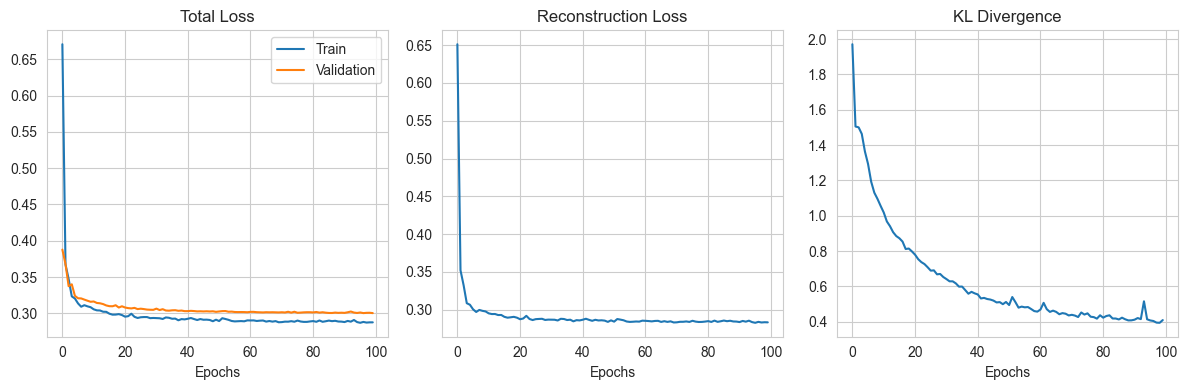

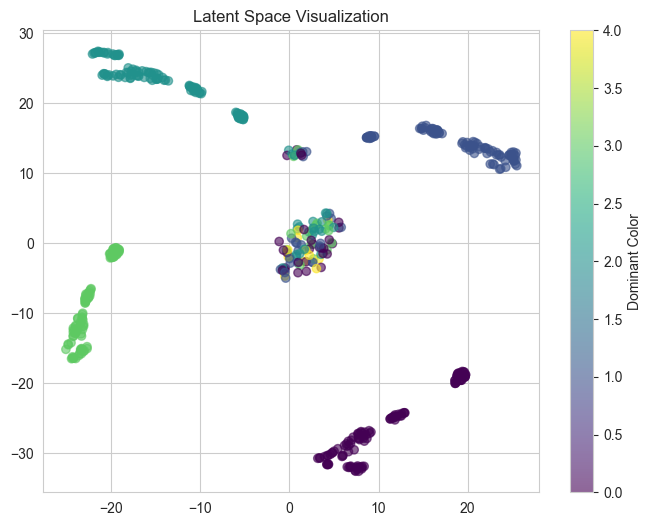

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

class EnhancedGraphVAE(nn.Module):
    def __init__(self, in_channels=13, hidden_channels=64, latent_dim=16, heads=4):
        super().__init__()

        # Encoder
        self.color_embed = nn.Linear(5, 3)  # 5 color channels -> 3D
        self.coord_norm = nn.BatchNorm1d(2)
        self.feat_norm = nn.BatchNorm1d(6)  # amino_VAL + 5 other features

        self.conv1 = GATConv(11, hidden_channels, heads=heads)  # 3 + 2 + 6 = 11
        self.conv2 = GATConv(hidden_channels*heads, hidden_channels, heads=heads)
        self.conv3 = GATConv(hidden_channels*heads, hidden_channels, heads=1)

        self.fc_mu = nn.Linear(hidden_channels, latent_dim)
        self.fc_logvar = nn.Linear(hidden_channels, latent_dim)

        # Decoder - now handling variable-sized graphs
        self.decoder_fc = nn.Linear(latent_dim, hidden_channels)
        self.decoder_node = nn.Linear(hidden_channels, hidden_channels)
        self.color_head = nn.Sequential(
            nn.Linear(hidden_channels, 5),
            nn.Softmax(dim=1)
        )
        self.feat_head = nn.Linear(hidden_channels, 8)  # 13-5=8 other features

    def encode(self, x, edge_index, batch):
        # Process features
        colors = self.color_embed(x[:, 1:6])
        coords = self.coord_norm(x[:, 9:11])
        other_feats = self.feat_norm(x[:, [0,6,7,8,11,12]])

        x = torch.cat([colors, coords, other_feats], dim=1)

        # GAT layers
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        # Global pooling - creates one embedding per graph
        x = global_mean_pool(x, batch)

        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, batch):
        """Decodes latent vectors back to node features for variable-sized graphs.

        Args:
            z: Latent vectors of shape [num_graphs, latent_dim]
            batch: PyG batch assignment vector of shape [num_nodes]
        """
        # Get graph-level features from latent space
        h_graph = F.relu(self.decoder_fc(z))

        # For each node, look up its graph's latent representation
        num_graphs = z.size(0)
        num_nodes = batch.size(0)

        # Create empty tensor for node embeddings
        h_nodes = torch.zeros(num_nodes, h_graph.size(1), device=z.device)

        # For each graph in the batch, assign its latent representation to its nodes
        for i in range(num_graphs):
            mask = (batch == i)
            h_nodes[mask] = h_graph[i]

        # Process node-level features through a decoder network
        h_nodes = F.relu(self.decoder_node(h_nodes))

        # Generate reconstructed features
        colors = self.color_head(h_nodes)
        feats = self.feat_head(h_nodes)

        # Concatenate to get final node features
        return torch.cat([feats[:, :1], colors, feats[:, 1:]], dim=1)

    def forward(self, x, edge_index, batch):
        mu, log_var = self.encode(x, edge_index, batch)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z, batch)
        return recon, mu, log_var


def train(model, train_loader, val_loader, epochs=100, lr=0.001, kl_weight=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    recon_losses = []
    kl_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon, mu, log_var = model(batch.x, batch.edge_index, batch.batch)

            # Check reconstruction shape before proceeding
            if epoch == 0 and len(recon_losses) == 0:
                print(f"Original shape: {batch.x.shape}")
                print(f"Reconstruction shape: {recon.shape}")

            # Make sure shapes match
            assert recon.shape == batch.x.shape, f"Shape mismatch: {recon.shape} vs {batch.x.shape}"

            # Reconstruction loss - now shapes should match
            recon_loss = F.mse_loss(recon, batch.x)

            # KL divergence
            kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

            # Total loss with KL weight
            loss = recon_loss + kl_weight * kl_loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

        # Track losses
        train_losses.append(epoch_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        kl_losses.append(epoch_kl_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon, mu, log_var = model(batch.x, batch.edge_index, batch.batch)
                recon_loss = F.mse_loss(recon, batch.x)
                kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
                val_loss += (recon_loss + kl_weight * kl_loss).item()

        val_losses.append(val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, '
                  f'Recon Loss: {recon_losses[-1]:.4f}, '
                  f'KL Loss: {kl_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'recon_losses': recon_losses,
        'kl_losses': kl_losses
    }


def visualize_training(losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(losses['train_losses'], label='Train')
    plt.plot(losses['val_losses'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(losses['recon_losses'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epochs')

    plt.subplot(1, 3, 3)
    plt.plot(losses['kl_losses'])
    plt.title('KL Divergence')
    plt.xlabel('Epochs')

    plt.tight_layout()
    plt.show()


def visualize_latent_space(model, loader, device):
    model.eval()
    latents = []
    colors = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, _ = model.encode(batch.x, batch.edge_index, batch.batch)
            latents.append(mu.cpu().numpy())

            # Get dominant color for each graph
            for i in range(batch.num_graphs):
                mask = batch.batch == i
                dom_color = batch.x[mask, 1:6].mean(0).argmax().item()
                colors.append(dom_color)

    latents = np.concatenate(latents)
    if latents.shape[1] > 2:
        latents = TSNE(n_components=2).fit_transform(latents)

    plt.figure(figsize=(8,6))
    plt.scatter(latents[:,0], latents[:,1], c=colors, cmap='viridis', alpha=0.6)
    plt.colorbar(label='Dominant Color')
    plt.title('Latent Space Visualization')
    plt.show()

if __name__ == "__main__":

    # Split dataset
    train_size = int(0.8 * len(dataset))
    train_dataset = dataset[:train_size]
    val_dataset = dataset[train_size:]

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model
    model = EnhancedGraphVAE()

    # Train model - try a smaller KL weight if the model isn't learning well
    losses = train(model, train_loader, val_loader, epochs=100, kl_weight=0.01)

    # Visualize training
    visualize_training(losses)

    # Visualize latent space
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    visualize_latent_space(model, val_loader, device)

This cell is a further model which differs from the previous one in that it uses a different latent space split. The model splits the latent space into two parts: one for node features and one for structural features. The model uses Graph Attention Networks (GATs) for encoding and decoding, and it includes a structure-aware pooling mechanism that pays more attention to structurally important nodes. The model also includes separate heads for reconstructing different node features (amino acid, color, size, charge, hydrophobicity, and structural features). The model also includes an edge prediction component that predicts whether an edge exists between two nodes. The model is trained using a custom loss function that combines node feature reconstruction loss, edge prediction loss, and KL divergence loss. The training loop tracks detailed losses for each component and can be used to visualize the training progress.

/Users/alexchilton/PycharmProjects/final_try/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/100 [00:00<?, ?it/s]

Original shape: torch.Size([482, 13])
Reconstruction shape: torch.Size([482, 13])
Original shape: torch.Size([452, 13])
Reconstruction shape: torch.Size([452, 13])
Original shape: torch.Size([449, 13])
Reconstruction shape: torch.Size([449, 13])
Original shape: torch.Size([444, 13])
Reconstruction shape: torch.Size([444, 13])
Original shape: torch.Size([448, 13])
Reconstruction shape: torch.Size([448, 13])
Original shape: torch.Size([431, 13])
Reconstruction shape: torch.Size([431, 13])
Original shape: torch.Size([427, 13])
Reconstruction shape: torch.Size([427, 13])
Original shape: torch.Size([450, 13])
Reconstruction shape: torch.Size([450, 13])
Original shape: torch.Size([448, 13])
Reconstruction shape: torch.Size([448, 13])
Original shape: torch.Size([486, 13])
Reconstruction shape: torch.Size([486, 13])
Original shape: torch.Size([450, 13])
Reconstruction shape: torch.Size([450, 13])
Original shape: torch.Size([485, 13])
Reconstruction shape: torch.Size([485, 13])
Original shape: 

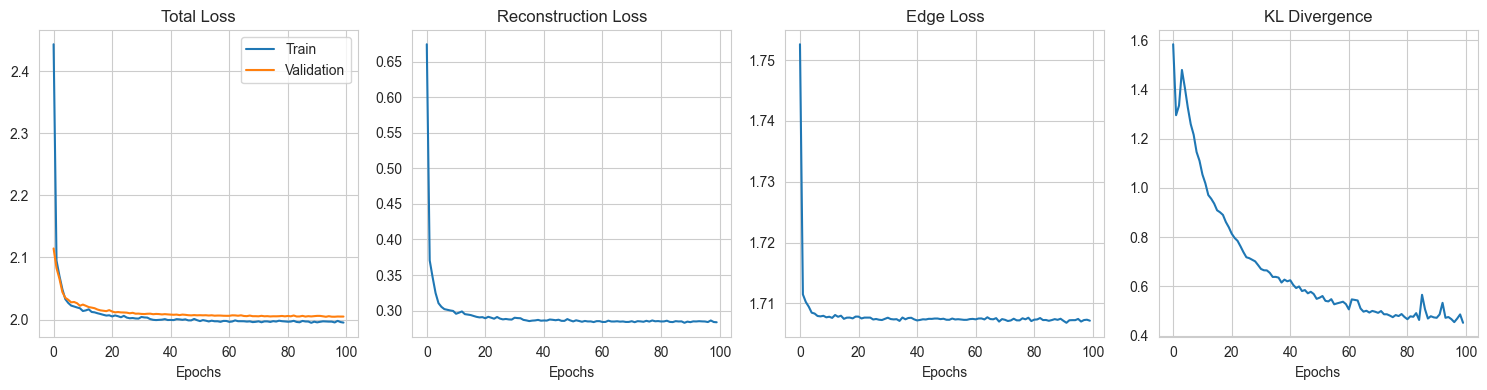

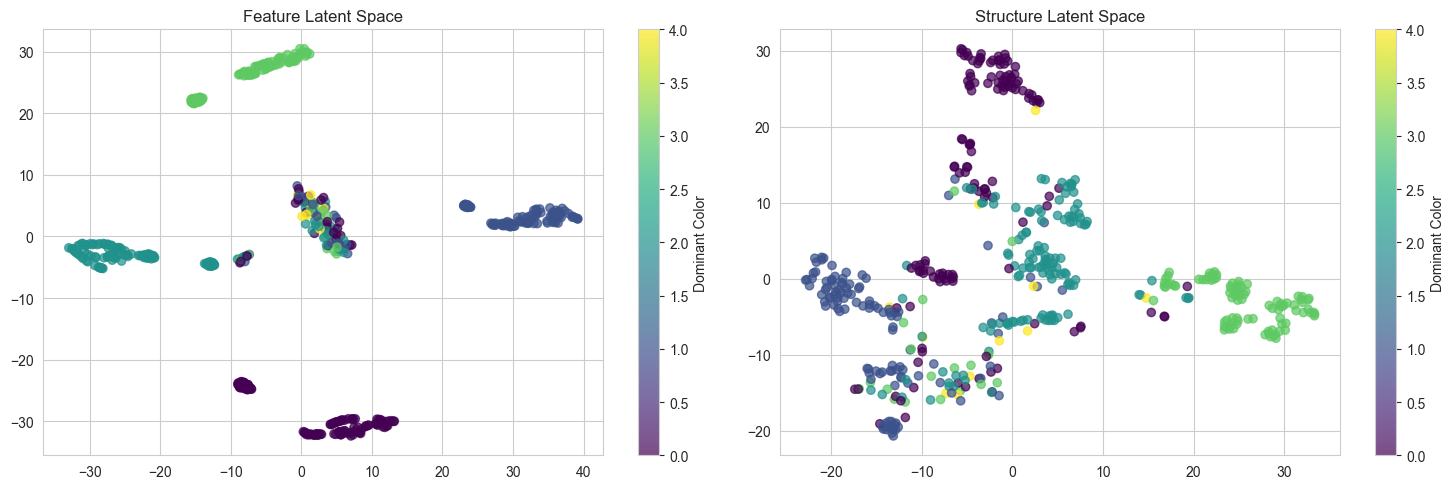

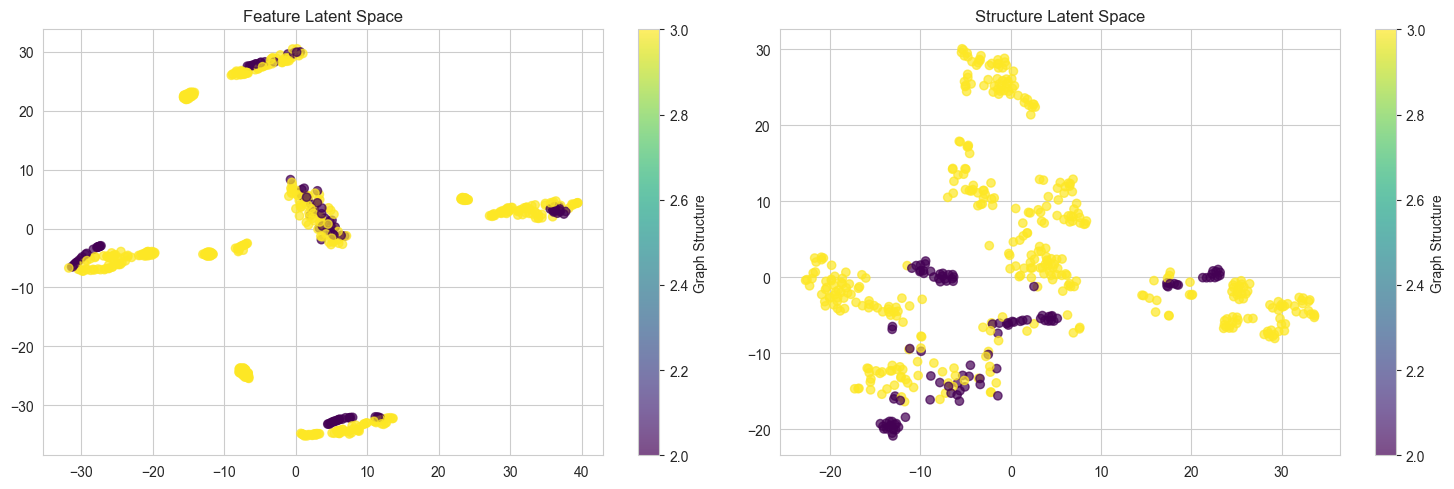

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x24 and 16x64)

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

class EnhancedGraphVAE2(nn.Module):
    def __init__(self, in_channels=13, hidden_channels=64, latent_dim=16, structure_latent_dim=8, heads=4):
        super().__init__()

        # Split the latent space into node features and structure
        self.latent_dim = latent_dim
        self.structure_latent_dim = structure_latent_dim
        self.total_latent_dim = latent_dim + structure_latent_dim

        # Encoder
        self.color_embed = nn.Linear(5, 3)  # 5 color channels -> 3D
        self.coord_norm = nn.BatchNorm1d(2)
        self.feat_norm = nn.BatchNorm1d(4)  # amino_VAL, size, charge, hydrophobicity

        # We now explicitly use degree and clustering as structural features
        self.struct_norm = nn.BatchNorm1d(2)  # degree, clustering

        self.conv1 = GATConv(11, hidden_channels, heads=heads)  # 3 (colors) + 2 (coords) + 4 (other_feats) + 2 (struct_feats) = 11
        self.conv2 = GATConv(hidden_channels*heads, hidden_channels, heads=heads)
        self.conv3 = GATConv(hidden_channels*heads, hidden_channels, heads=1)

        # Structure-aware pooling with attention
        self.struct_attention = nn.Sequential(
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )

        # Separate feature and structure latent spaces
        self.fc_mu_feat = nn.Linear(hidden_channels, latent_dim)
        self.fc_logvar_feat = nn.Linear(hidden_channels, latent_dim)

        self.fc_mu_struct = nn.Linear(hidden_channels, structure_latent_dim)
        self.fc_logvar_struct = nn.Linear(hidden_channels, structure_latent_dim)

        # Decoder - Feature reconstruction
        self.decoder_fc = nn.Linear(self.total_latent_dim, hidden_channels)
        self.decoder_node = nn.Linear(hidden_channels, hidden_channels)

        # Node feature heads
        self.amino_head = nn.Linear(hidden_channels, 1)
        self.color_head = nn.Sequential(
            nn.Linear(hidden_channels, 5),
            nn.Softmax(dim=1)
        )
        self.feat_head = nn.Linear(hidden_channels, 3)  # size, charge, hydrophobicity
        self.coord_head = nn.Linear(hidden_channels, 2)  # x_coord, y_coord
        self.struct_feat_head = nn.Linear(hidden_channels, 2)  # degree, clustering

        # Edge prediction components
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )

    def encode(self, x, edge_index, batch):
        # Process node features - split into different feature types
        colors = self.color_embed(x[:, 1:6])
        coords = self.coord_norm(x[:, 9:11])
        struct_feats = self.struct_norm(x[:, 11:13])  # degree, clustering
        other_feats = self.feat_norm(x[:, [0,6,7,8]])  # amino_val, size, charge, hydrophobicity

        # Concatenate processed features
        x = torch.cat([colors, coords, other_feats, struct_feats], dim=1)

        # Graph attention layers
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv3(x, edge_index)

        # Structure-aware pooling - pay more attention to structurally important nodes
        node_attention = self.struct_attention(x)
        x_weighted = x * node_attention

        # Global pooling with attention weights
        pooled = global_mean_pool(x_weighted, batch)

        # Split into feature and structure latent spaces
        mu_feat = self.fc_mu_feat(pooled)
        logvar_feat = self.fc_logvar_feat(pooled)

        mu_struct = self.fc_mu_struct(pooled)
        logvar_struct = self.fc_logvar_struct(pooled)

        return (mu_feat, logvar_feat), (mu_struct, logvar_struct)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_node_features(self, z_combined, batch):
        """Decode latent vectors to node features."""
        # Get graph-level features from latent space
        h_graph = F.relu(self.decoder_fc(z_combined))

        # Map to nodes
        num_graphs = z_combined.size(0)
        num_nodes = batch.size(0)

        # Create node embeddings
        h_nodes = torch.zeros(num_nodes, h_graph.size(1), device=z_combined.device)

        # Map graph embeddings to nodes
        for i in range(num_graphs):
            mask = (batch == i)
            h_nodes[mask] = h_graph[i]

        # Process through node decoder
        h_nodes = F.relu(self.decoder_node(h_nodes))

        # Generate node features through different heads
        amino_val = self.amino_head(h_nodes)
        colors = self.color_head(h_nodes)
        feats = self.feat_head(h_nodes)  # size, charge, hydrophobicity
        coords = self.coord_head(h_nodes)  # x, y
        struct_feats = self.struct_feat_head(h_nodes)  # degree, clustering

        # Concatenate all features
        return torch.cat([
            amino_val,             # 1
            colors,                # 5
            feats,                 # 3
            coords,                # 2
            struct_feats           # 2
        ], dim=1)

    def predict_edges(self, h_nodes, batch):
        """Predict edges between nodes based on node embeddings."""
        edge_logits = []

        for i in range(batch.max().item() + 1):  # For each graph
            mask = (batch == i)
            nodes_i = h_nodes[mask]  # Node embeddings for this graph
            n = nodes_i.size(0)

            if n <= 1:  # Skip graphs with only one node
                continue

            # Generate all potential edges (without duplicates)
            src_nodes = []
            tgt_nodes = []
            for j in range(n):
                for k in range(j+1, n):
                    src_nodes.append(j)
                    tgt_nodes.append(k)

            src_nodes = torch.tensor(src_nodes, device=h_nodes.device)
            tgt_nodes = torch.tensor(tgt_nodes, device=h_nodes.device)

            # Get node embeddings for these pairs
            src_embeds = nodes_i[src_nodes]
            tgt_embeds = nodes_i[tgt_nodes]

            # Concatenate source and target embeddings
            pair_embeds = torch.cat([src_embeds, tgt_embeds], dim=1)

            # Predict edge probabilities
            edge_probs = self.edge_mlp(pair_embeds)

            edge_logits.append({
                'batch_idx': i,
                'src_nodes': src_nodes.cpu().tolist(),
                'tgt_nodes': tgt_nodes.cpu().tolist(),
                'probs': edge_probs
            })

        return edge_logits

    def decode(self, z_feat, z_struct, batch):
        """Decode latent vectors to node features and edges."""
        # Combine feature and structure latent vectors
        z_combined = torch.cat([z_feat, z_struct], dim=1)

        # Get graph-level features from latent space
        h_graph = F.relu(self.decoder_fc(z_combined))

        # Map to nodes
        num_nodes = batch.size(0)

        # Create node embeddings
        h_nodes = torch.zeros(num_nodes, h_graph.size(1), device=z_combined.device)

        # Map graph embeddings to nodes
        for i in range(z_combined.size(0)):
            mask = (batch == i)
            h_nodes[mask] = h_graph[i]

        # Process through node decoder
        h_nodes = F.relu(self.decoder_node(h_nodes))

        # Generate node features
        node_features = self.decode_node_features(z_combined, batch)

        # Predict edges
        edge_logits = self.predict_edges(h_nodes, batch)

        return node_features, edge_logits

    def forward(self, x, edge_index, batch):
        # Encode
        (mu_feat, logvar_feat), (mu_struct, logvar_struct) = self.encode(x, edge_index, batch)

        # Reparameterize
        z_feat = self.reparameterize(mu_feat, logvar_feat)
        z_struct = self.reparameterize(mu_struct, logvar_struct)

        # Decode
        node_features, edge_logits = self.decode(z_feat, z_struct, batch)

        return node_features, edge_logits, (mu_feat, logvar_feat), (mu_struct, logvar_struct)


def compute_edge_loss(edge_logits, edge_index, batch):
    """Compute loss for edge prediction."""
    if not edge_logits:
        return torch.tensor(0.0, device=edge_index.device)

    losses = []
    for edge_info in edge_logits:
        b = edge_info['batch_idx']
        # Get true edges for this graph
        mask = (batch[edge_index[0]] == b)
        true_edges = edge_index[:, mask]

        # Get the offset for this graph's nodes
        node_offset = (batch == b).nonzero()[0,0]
        true_edges = true_edges - node_offset  # Convert to 0-based indexing

        # Create target adjacency matrix
        num_nodes = (batch == b).sum()
        adj = torch.zeros(num_nodes, num_nodes, device=edge_index.device)

        if true_edges.numel() > 0:  # Only if edges exist
            adj[true_edges[0], true_edges[1]] = 1

        # Get predicted edges
        src = torch.tensor(edge_info['src_nodes'], device=edge_index.device)
        tgt = torch.tensor(edge_info['tgt_nodes'], device=edge_index.device)
        probs = edge_info['probs'].squeeze()

        if adj.sum() > 0:  # Only calculate loss if positive edges exist
            pos_weight = torch.tensor([(num_nodes**2 - adj.sum()) / adj.sum()],
                                      device=edge_index.device)
            loss = F.binary_cross_entropy(
                probs,
                adj[src, tgt],
                weight=torch.where(adj[src, tgt] == 1, pos_weight, torch.tensor(1.0, device=edge_index.device))
            )
            losses.append(loss)

    return torch.mean(torch.stack(losses)) if losses else torch.tensor(0.0, device=edge_index.device)


def train(model, train_loader, val_loader, epochs=100, lr=0.001, kl_weight=0.01, edge_weight=1.0, structure_weight=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    recon_losses = []
    edge_losses = []
    kl_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_edge_loss = 0
        epoch_kl_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            node_features, edge_logits, (mu_feat, logvar_feat), (mu_struct, logvar_struct) = model(
                batch.x, batch.edge_index, batch.batch
            )

            # Check shapes
            if epoch == 0 and len(recon_losses) == 0:
                print(f"Original shape: {batch.x.shape}")
                print(f"Reconstruction shape: {node_features.shape}")

            # Node feature reconstruction loss
            recon_loss = F.mse_loss(node_features, batch.x)

            # Edge prediction loss
            edge_loss = compute_edge_loss(edge_logits, batch.edge_index, batch.batch)

            # KL divergence - feature space
            kl_loss_feat = -0.5 * torch.mean(1 + logvar_feat - mu_feat.pow(2) - logvar_feat.exp())

            # KL divergence - structure space
            kl_loss_struct = -0.5 * torch.mean(1 + logvar_struct - mu_struct.pow(2) - logvar_struct.exp())

            # Total KL loss with weighting for structure vs. features
            kl_loss = kl_loss_feat + structure_weight * kl_loss_struct

            # Total loss with weighting
            loss = recon_loss + edge_weight * edge_loss + kl_weight * kl_loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_edge_loss += edge_loss.item()
            epoch_kl_loss += kl_loss.item()

        # Track losses
        train_losses.append(epoch_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        edge_losses.append(epoch_edge_loss / len(train_loader))
        kl_losses.append(epoch_kl_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                node_features, edge_logits, (mu_feat, logvar_feat), (mu_struct, logvar_struct) = model(
                    batch.x, batch.edge_index, batch.batch
                )

                recon_loss = F.mse_loss(node_features, batch.x)
                edge_loss = compute_edge_loss(edge_logits, batch.edge_index, batch.batch)
                kl_loss_feat = -0.5 * torch.mean(1 + logvar_feat - mu_feat.pow(2) - logvar_feat.exp())
                kl_loss_struct = -0.5 * torch.mean(1 + logvar_struct - mu_struct.pow(2) - logvar_struct.exp())
                kl_loss = kl_loss_feat + structure_weight * kl_loss_struct

                val_loss += (recon_loss + edge_weight * edge_loss + kl_weight * kl_loss).item()

        val_losses.append(val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, '
                  f'Recon Loss: {recon_losses[-1]:.4f}, '
                  f'Edge Loss: {edge_losses[-1]:.4f}, '
                  f'KL Loss: {kl_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'recon_losses': recon_losses,
        'edge_losses': edge_losses,
        'kl_losses': kl_losses
    }


def visualize_training(losses):
    """Visualize training metrics."""
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    plt.plot(losses['train_losses'], label='Train')
    plt.plot(losses['val_losses'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(losses['recon_losses'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epochs')

    plt.subplot(1, 4, 3)
    plt.plot(losses['edge_losses'])
    plt.title('Edge Loss')
    plt.xlabel('Epochs')

    plt.subplot(1, 4, 4)
    plt.plot(losses['kl_losses'])
    plt.title('KL Divergence')
    plt.xlabel('Epochs')

    plt.tight_layout()
    plt.show()


def visualize_latent_space(model, loader, device, color_by='color'):
    """
    Visualize latent space with options for coloring by node color or graph type.

    Args:
        model: Trained model
        loader: Data loader
        device: Device to run model on
        color_by: 'color' or 'structure' to determine coloring scheme
    """
    model.eval()
    feat_latents = []
    struct_latents = []
    colors = []
    structures = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            (mu_feat, _), (mu_struct, _) = model.encode(batch.x, batch.edge_index, batch.batch)
            feat_latents.append(mu_feat.cpu().numpy())
            struct_latents.append(mu_struct.cpu().numpy())

            # Extract coloring info
            for i in range(batch.num_graphs):
                mask = batch.batch == i

                # Get dominant color for each graph
                dom_color = batch.x[mask, 1:6].mean(0).argmax().item()
                colors.append(dom_color)

                # Try to infer graph structure type from the features
                # This is approximate - you might need to adapt based on your data
                nodes = mask.sum().item()
                edges = (batch.batch[batch.edge_index[0]] == i).sum().item() // 2
                avg_degree = edges * 2 / nodes if nodes > 0 else 0
                clustering = batch.x[mask, 12].mean().item()

                # Simple heuristic to guess graph type
                if abs(avg_degree - 2) < 0.5 and nodes > 3:  # Circle has degree ~2
                    structures.append(0)  # Circle
                elif avg_degree > nodes * 0.8:  # Almost complete graph
                    structures.append(1)  # Grid/complete
                elif clustering < 0.1 and max(batch.x[mask, 11]) > nodes * 0.7:  # Star has one high-degree node
                    structures.append(2)  # Star
                else:
                    structures.append(3)  # Random/other

    # Concatenate all latents
    feat_latents = np.concatenate(feat_latents)
    struct_latents = np.concatenate(struct_latents)

    # Use TSNE for visualization if dimensions are high
    plt.figure(figsize=(15, 5))

    # Plot feature latent space
    plt.subplot(1, 2, 1)
    if feat_latents.shape[1] > 2:
        feat_latents_2d = TSNE(n_components=2, perplexity=min(30, len(feat_latents)-1)).fit_transform(feat_latents)
    else:
        feat_latents_2d = feat_latents

    color_values = colors if color_by == 'color' else structures
    color_label = 'Dominant Color' if color_by == 'color' else 'Graph Structure'

    plt.scatter(feat_latents_2d[:,0], feat_latents_2d[:,1], c=color_values, cmap='viridis', alpha=0.7)
    plt.colorbar(label=color_label)
    plt.title('Feature Latent Space')

    # Plot structure latent space
    plt.subplot(1, 2, 2)
    if struct_latents.shape[1] > 2:
        struct_latents_2d = TSNE(n_components=2, perplexity=min(30, len(struct_latents)-1)).fit_transform(struct_latents)
    else:
        struct_latents_2d = struct_latents

    plt.scatter(struct_latents_2d[:,0], struct_latents_2d[:,1], c=color_values, cmap='viridis', alpha=0.7)
    plt.colorbar(label=color_label)
    plt.title('Structure Latent Space')

    plt.tight_layout()
    plt.show()


def generate_graphs(model, num_samples=5, device='cpu'):
    """Generate new graphs from random points in the latent space."""
    model.eval()

    # Use the model's actual latent dimensions
    latent_dim = model.latent_dim
    structure_latent_dim = model.structure_latent_dim

    with torch.no_grad():
        # Sample random points in latent space
        z_feat = torch.randn(num_samples, latent_dim).to(device)
        z_struct = torch.randn(num_samples, structure_latent_dim).to(device)

        # Create fake batch assignment for a single node per graph initially
        batch = torch.arange(num_samples, device=device)

        # Combine the latent vectors
        z_combined = torch.cat([z_feat, z_struct], dim=1)

        # Initial generation to get node embeddings
        h_graph = F.relu(model.decoder_fc(z_combined))

        generated_graphs = []

        for i in range(num_samples):
            # Start with a single node embedding
            h_node = h_graph[i].unsqueeze(0)

            # Generate initial node features
            node_embed = F.relu(model.decoder_node(h_node))

            # Create node features using the model's specific heads
            amino_val = model.amino_head(node_embed)
            colors = model.color_head(node_embed)
            feats = model.feat_head(node_embed)
            coords = model.coord_head(node_embed)
            struct_feats = model.struct_feat_head(node_embed)

            # Concatenate to form initial node features
            node_features = torch.cat([
                amino_val, colors, feats, coords, struct_feats
            ], dim=1)

            # Decide on number of nodes (between 4 and 15)
            num_nodes = np.random.randint(4, 16)

            # Generate more nodes
            for _ in range(num_nodes - 1):
                # Generate position with some randomness
                new_coords = coords[-1] + torch.randn(1, 2, device=device) * 0.5

                # Create new node embedding (using the same graph embedding)
                new_node_embed = F.relu(model.decoder_node(h_node))

                # Generate features for the new node
                new_amino = model.amino_head(new_node_embed)
                new_colors = model.color_head(new_node_embed)
                new_feats = model.feat_head(new_node_embed)
                new_struct = model.struct_feat_head(new_node_embed)

                # Concatenate new node features
                new_node = torch.cat([
                    new_amino, new_colors, new_feats, new_coords, new_struct
                ], dim=1)

                # Add to existing nodes
                node_features = torch.cat([node_features, new_node], dim=0)
                coords = torch.cat([coords, new_coords], dim=0)
                node_embed = torch.cat([node_embed, new_node_embed], dim=0)

            # Generate edges
            edge_index = [[], []]
            for j in range(num_nodes):
                for k in range(j+1, num_nodes):
                    # Get node embeddings
                    src_embed = node_embed[j].unsqueeze(0)
                    tgt_embed = node_embed[k].unsqueeze(0)

                    # Predict edge probability
                    pair_embed = torch.cat([src_embed, tgt_embed], dim=1)
                    edge_prob = model.edge_mlp(pair_embed)

                    # Add edge if probability is high enough
                    if edge_prob.item() > 0.5:
                        edge_index[0].extend([j, k])
                        edge_index[1].extend([k, j])

            # Store generated graph
            generated_graphs.append({
                'node_features': node_features.cpu().numpy(),
                'edge_index': torch.tensor(edge_index).cpu().numpy() if edge_index[0] else np.zeros((2, 0), dtype=np.int64),
                'num_nodes': num_nodes
            })

    return generated_graphs


def visualize_generated_graphs(generated_graphs):
    """Visualize the generated graphs."""
    num_graphs = len(generated_graphs)
    fig, axes = plt.subplots(1, num_graphs, figsize=(4*num_graphs, 4))

    if num_graphs == 1:
        axes = [axes]

    for i, graph in enumerate(generated_graphs):
        ax = axes[i]
        node_features = graph['node_features']
        edge_index = graph['edge_index']

        # Extract coordinates
        coords = node_features[:, 9:11]

        # Extract colors (indices 1-5 are the color channels)
        colors = node_features[:, 1:6]
        color_idx = np.argmax(colors, axis=1)

        # Map color indices to actual colors
        color_map = {
            0: 'red',
            1: 'green',
            2: 'blue',
            3: 'yellow',
            4: 'purple'
        }
        node_colors = [color_map[idx] for idx in color_idx]

        # Draw nodes
        ax.scatter(coords[:, 0], coords[:, 1], c=node_colors, s=100)

        # Draw edges
        for j in range(0, len(edge_index[0]), 2):  # Only draw once per edge
            src, tgt = edge_index[0][j], edge_index[1][j]
            ax.plot([coords[src, 0], coords[tgt, 0]],
                    [coords[src, 1], coords[tgt, 1]], 'k-', alpha=0.5)

        ax.set_title(f"Generated Graph {i+1}")
        ax.set_aspect('equal')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Assuming you have a PyG dataset loaded
    # dataset = YourDataset()

    # Split dataset
    train_size = int(0.8 * len(dataset))
    train_dataset = dataset[:train_size]
    val_dataset = dataset[train_size:]

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model with separate latent spaces for features and structure
    model = EnhancedGraphVAE2(latent_dim=12, structure_latent_dim=4)

    # Train model with different loss weights
    losses = train(
        model,
        train_loader,
        val_loader,
        epochs=100,
        lr=0.001,
        kl_weight=0.01,  # Overall KL weight
        edge_weight=1.0,  # Edge prediction importance
        structure_weight=2.0  # How much to emphasize structure vs. features in KL
    )

    # Visualize training progress
    visualize_training(losses)

    # Visualize latent spaces
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Colored by node dominant color
    visualize_latent_space(model, val_loader, device, color_by='color')

    # Colored by inferred graph structure
    visualize_latent_space(model, val_loader, device, color_by='structure')

    # Generate new graphs
    generated_graphs = generate_graphs(model, num_samples=5, device=device)

    # Visualize generated graphs
    visualize_generated_graphs(generated_graphs)

this cell generates new graphs from the latent space.

In [77]:
def generate_graphs(model, num_samples=5, device='cpu'):
    """Generate new graphs from random points in the latent space."""
    model.eval()

    # Use the model's actual latent dimensions
    latent_dim = model.latent_dim
    structure_latent_dim = model.structure_latent_dim

    with torch.no_grad():
        # Sample random points in latent space
        z_feat = torch.randn(num_samples, latent_dim).to(device)
        z_struct = torch.randn(num_samples, structure_latent_dim).to(device)

        # Create fake batch assignment for a single node per graph initially
        batch = torch.arange(num_samples, device=device)

        # Combine the latent vectors
        z_combined = torch.cat([z_feat, z_struct], dim=1)

        # Initial generation to get node embeddings
        h_graph = F.relu(model.decoder_fc(z_combined))

        generated_graphs = []

        for i in range(num_samples):
            # Start with a single node embedding
            h_node = h_graph[i].unsqueeze(0)

            # Generate initial node features
            node_embed = F.relu(model.decoder_node(h_node))

            # Create node features using the model's specific heads
            amino_val = model.amino_head(node_embed)
            colors = model.color_head(node_embed)
            feats = model.feat_head(node_embed)
            coords = model.coord_head(node_embed)
            struct_feats = model.struct_feat_head(node_embed)

            # Concatenate to form initial node features
            node_features = torch.cat([
                amino_val, colors, feats, coords, struct_feats
            ], dim=1)

            # Decide on number of nodes (between 4 and 15)
            num_nodes = np.random.randint(4, 16)

            # Generate more nodes
            for _ in range(num_nodes - 1):
                # Generate position with some randomness
                new_coords = coords[-1] + torch.randn(1, 2, device=device) * 0.5

                # Create new node embedding (using the same graph embedding)
                new_node_embed = F.relu(model.decoder_node(h_node))

                # Generate features for the new node
                new_amino = model.amino_head(new_node_embed)
                new_colors = model.color_head(new_node_embed)
                new_feats = model.feat_head(new_node_embed)
                new_struct = model.struct_feat_head(new_node_embed)

                # Concatenate new node features
                new_node = torch.cat([
                    new_amino, new_colors, new_feats, new_coords, new_struct
                ], dim=1)

                # Add to existing nodes
                node_features = torch.cat([node_features, new_node], dim=0)
                coords = torch.cat([coords, new_coords], dim=0)
                node_embed = torch.cat([node_embed, new_node_embed], dim=0)

            # Generate edges
            edge_index = [[], []]
            for j in range(num_nodes):
                for k in range(j+1, num_nodes):
                    # Get node embeddings
                    src_embed = node_embed[j].unsqueeze(0)
                    tgt_embed = node_embed[k].unsqueeze(0)

                    # Predict edge probability
                    pair_embed = torch.cat([src_embed, tgt_embed], dim=1)
                    edge_prob = model.edge_mlp(pair_embed)

                    # Add edge if probability is high enough
                    if edge_prob.item() > 0.7:
                        edge_index[0].extend([j, k])
                        edge_index[1].extend([k, j])

            # Store generated graph
            generated_graphs.append({
                'node_features': node_features.cpu().numpy(),
                'edge_index': torch.tensor(edge_index).cpu().numpy() if edge_index[0] else np.zeros((2, 0), dtype=np.int64),
                'num_nodes': num_nodes
            })

    return generated_graphs


In [78]:
# Generate new graphs
generated_graphs = generate_graphs(model, num_samples=5, device=device)


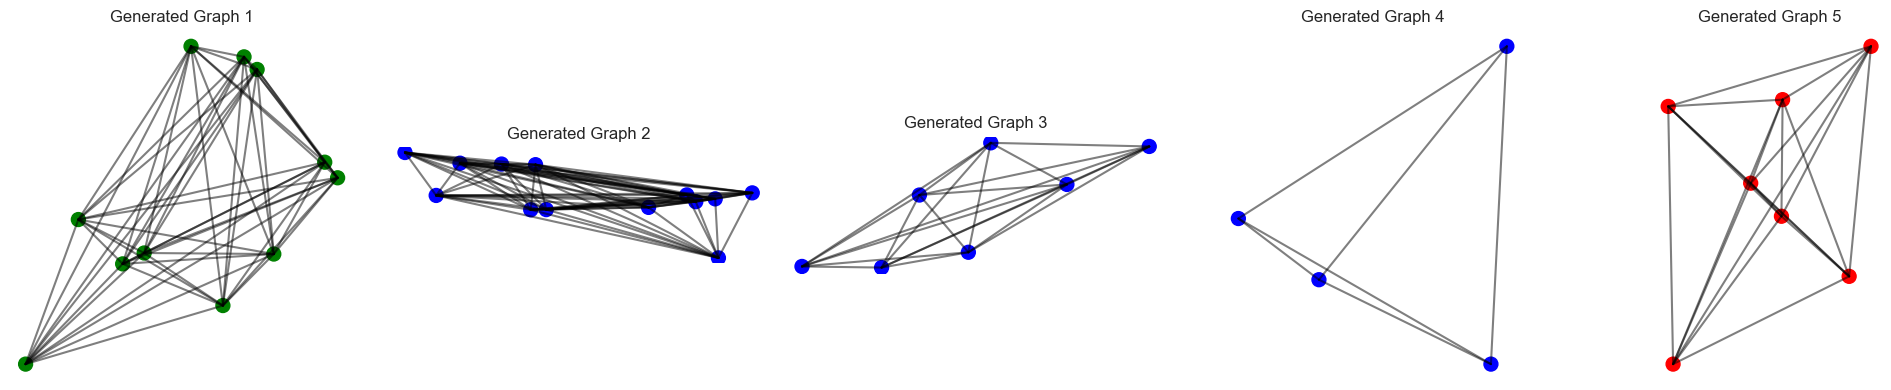

In [79]:
 # Visualize generated graphs
visualize_generated_graphs(generated_graphs)

this cell generates new graphs from the latent space.but it is generating bassed on the cluster centers. ie it is trying to get the different shapes and try to make graphs based on the shapes

In [91]:
def identify_cluster_centers(model, loader, device, num_clusters=5):
    """
    Identify centers of clusters in the structure latent space.
    Prints debug information to help understand the clustering.
    """
    model.eval()
    struct_latents = []
    labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            # Extract structural latent representations
            (_, _), (mu_struct, _) = model.encode(batch.x, batch.edge_index, batch.batch)
            struct_latents.append(mu_struct.cpu().numpy())

            # Simple graph classification based on structural properties
            for i in range(batch.num_graphs):
                mask = batch.batch == i
                # Extract structural features for this graph
                degree = batch.x[mask, 11].mean().item()
                clustering = batch.x[mask, 12].mean().item()
                num_nodes = mask.sum().item()
                num_edges = (batch.batch[batch.edge_index[0]] == i).sum().item() // 2

                # Print debug info for a few graphs
                if len(labels) < 5:
                    print(f"Graph {len(labels)}: nodes={num_nodes}, edges={num_edges}, "
                          f"avg_degree={degree:.2f}, clustering={clustering:.2f}")

                # Classify based on structural properties
                if abs(degree - 2.0) < 0.3:
                    # Circle-like: degree close to 2
                    labels.append(0)
                elif num_nodes > 5 and degree > 3.0 and clustering > 0.2:
                    # Grid-like: high degree and clustering
                    labels.append(1)
                elif clustering < 0.1 and degree > 1.8:
                    # Star-like: low clustering, medium degree
                    labels.append(2)
                elif degree < 2.0:
                    # Tree/path-like: low degree
                    labels.append(3)
                else:
                    # Random/other
                    labels.append(4)

    struct_latents = np.concatenate(struct_latents)
    labels = np.array(labels)

    # Print counts for each label
    for i in range(5):
        count = np.sum(labels == i)
        print(f"Label {i} count: {count}")

    # Calculate center for each cluster
    centers = []
    for i in range(num_clusters):
        if np.sum(labels == i) > 0:
            center = struct_latents[labels == i].mean(axis=0)
            centers.append(center)
            print(f"Cluster {i} center shape: {center.shape}")
        else:
            print(f"No samples for cluster {i}!")
            # Use zero vector as a fallback
            centers.append(np.zeros(struct_latents.shape[1]))

    return centers, labels

def generate_graphs_by_type(model, type_idx, centers, num_samples=5, variance=0.5, edge_threshold=0.5, device='cpu'):
    """
    Generate graphs of a specific structural type.
    Includes debugging information and error handling.
    """
    model.eval()

    # Get structure latent dimension from model
    latent_dim = model.latent_dim
    structure_latent_dim = model.structure_latent_dim

    print(f"Generating {num_samples} graphs of type {type_idx}")
    print(f"Feature latent dim: {latent_dim}, Structure latent dim: {structure_latent_dim}")

    # Check if we have a valid center
    if type_idx >= len(centers):
        print(f"Error: type_idx {type_idx} is out of range (0-{len(centers)-1})")
        return []

    center = centers[type_idx]
    if np.all(center == 0):
        print(f"Warning: Using zero vector for cluster {type_idx}. This may not produce good results.")

    print(f"Center vector: {center[:5]}... (showing first 5 values)")

    with torch.no_grad():
        # Sample feature space randomly
        z_feat = torch.randn(num_samples, latent_dim).to(device)

        # Sample structure space near the chosen center
        center_tensor = torch.tensor(center, dtype=torch.float32).to(device)
        center_tensor = center_tensor.repeat(num_samples, 1)
        noise = torch.randn(num_samples, structure_latent_dim).to(device) * variance
        z_struct = center_tensor + noise

        print(f"z_feat shape: {z_feat.shape}, z_struct shape: {z_struct.shape}")

        # Use the existing generation function with our latent vectors
        return generate_graphs_with_latent(model, z_feat, z_struct, edge_threshold=edge_threshold, device=device)

def generate_graphs_with_latent(model, z_feat, z_struct, edge_threshold=0.5, device='cpu'):
    """Modified version of generate_graphs that accepts specific latent vectors"""
    model.eval()
    num_samples = z_feat.size(0)

    print(f"Generating {num_samples} graphs with edge threshold {edge_threshold}")

    with torch.no_grad():
        # Combine the latent vectors
        z_combined = torch.cat([z_feat, z_struct], dim=1)

        # Initial generation to get node embeddings
        h_graph = F.relu(model.decoder_fc(z_combined))

        generated_graphs = []

        for i in range(num_samples):
            # Start with a single node embedding
            h_node = h_graph[i].unsqueeze(0)

            # Generate initial node features
            node_embed = F.relu(model.decoder_node(h_node))

            # Create node features using the model's specific heads
            amino_val = model.amino_head(node_embed)
            colors = model.color_head(node_embed)
            feats = model.feat_head(node_embed)
            coords = model.coord_head(node_embed)
            struct_feats = model.struct_feat_head(node_embed)

            # Concatenate to form initial node features
            node_features = torch.cat([
                amino_val, colors, feats, coords, struct_feats
            ], dim=1)

            # Decide on number of nodes (between 4 and 15)
            num_nodes = np.random.randint(4, 16)

            # Generate more nodes
            for _ in range(num_nodes - 1):
                # Generate position with some randomness
                new_coords = coords[-1] + torch.randn(1, 2, device=device) * 0.5

                # Create new node embedding
                new_node_embed = F.relu(model.decoder_node(h_node))

                # Generate features for the new node
                new_amino = model.amino_head(new_node_embed)
                new_colors = model.color_head(new_node_embed)
                new_feats = model.feat_head(new_node_embed)
                new_struct = model.struct_feat_head(new_node_embed)

                # Concatenate new node features
                new_node = torch.cat([
                    new_amino, new_colors, new_feats, new_coords, new_struct
                ], dim=1)

                # Add to existing nodes
                node_features = torch.cat([node_features, new_node], dim=0)
                coords = torch.cat([coords, new_coords], dim=0)
                node_embed = torch.cat([node_embed, new_node_embed], dim=0)

            # Generate edges
            edge_index = [[], []]
            edge_count = 0

            for j in range(num_nodes):
                for k in range(j+1, num_nodes):
                    # Get node embeddings
                    src_embed = node_embed[j].unsqueeze(0)
                    tgt_embed = node_embed[k].unsqueeze(0)

                    # Predict edge probability
                    pair_embed = torch.cat([src_embed, tgt_embed], dim=1)
                    edge_prob = model.edge_mlp(pair_embed).item()

                    # Add edge if probability is high enough
                    if edge_prob > edge_threshold:
                        edge_index[0].extend([j, k])
                        edge_index[1].extend([k, j])
                        edge_count += 1

            print(f"Graph {i}: {num_nodes} nodes, {edge_count} edges")

            # Store generated graph
            generated_graphs.append({
                'node_features': node_features.cpu().numpy(),
                'edge_index': torch.tensor(edge_index).cpu().numpy() if edge_index[0] else np.zeros((2, 0), dtype=np.int64),
                'num_nodes': num_nodes
            })

    return generated_graphs

# Structure-specific generation with adjusted parameters
def generate_circle_graph(model, centers, num_samples=1, device='cpu'):
    """Generate a circle-like graph with high edge threshold and low variance"""
    return generate_graphs_by_type(
        model, type_idx=0, centers=centers,
        num_samples=num_samples,
        variance=0.2,  # Low variance to stay close to prototype
        edge_threshold=0.7,  # High threshold for sparse connections
        device=device
    )

def generate_grid_graph(model, centers, num_samples=1, device='cpu'):
    """Generate a grid-like graph with medium edge threshold"""
    return generate_graphs_by_type(
        model, type_idx=1, centers=centers,
        num_samples=num_samples,
        variance=0.3,
        edge_threshold=0.6,
        device=device
    )

def generate_star_graph(model, centers, num_samples=1, device='cpu'):
    """Generate a star-like graph with high edge threshold"""
    return generate_graphs_by_type(
        model, type_idx=2, centers=centers,
        num_samples=num_samples,
        variance=0.3,
        edge_threshold=0.8,  # Very high threshold to ensure sparse star structure
        device=device
    )

def generate_tree_graph(model, centers, num_samples=1, device='cpu'):
    """Generate a tree-like graph with high edge threshold"""
    return generate_graphs_by_type(
        model, type_idx=3, centers=centers,
        num_samples=num_samples,
        variance=0.4,
        edge_threshold=0.75,
        device=device
    )

# Example usage:
"""
# First identify cluster centers
centers, labels = identify_cluster_centers(model, val_loader, device)

# Generate different graph types
circle_graphs = generate_circle_graph(model, centers, num_samples=3, device=device)
grid_graphs = generate_grid_graph(model, centers, num_samples=3, device=device)
star_graphs = generate_star_graph(model, centers, num_samples=3, device=device)
tree_graphs = generate_tree_graph(model, centers, num_samples=3, device=device)

# Visualize
visualize_generated_graphs(circle_graphs)
visualize_generated_graphs(grid_graphs)
visualize_generated_graphs(star_graphs)
visualize_generated_graphs(tree_graphs)
"""

'\n# First identify cluster centers\ncenters, labels = identify_cluster_centers(model, val_loader, device)\n\n# Generate different graph types\ncircle_graphs = generate_circle_graph(model, centers, num_samples=3, device=device)\ngrid_graphs = generate_grid_graph(model, centers, num_samples=3, device=device)\nstar_graphs = generate_star_graph(model, centers, num_samples=3, device=device)\ntree_graphs = generate_tree_graph(model, centers, num_samples=3, device=device)\n\n# Visualize\nvisualize_generated_graphs(circle_graphs)\nvisualize_generated_graphs(grid_graphs)\nvisualize_generated_graphs(star_graphs)\nvisualize_generated_graphs(tree_graphs)\n'

Graph 0: nodes=8, edges=3, avg_degree=1.75, clustering=0.00
Graph 1: nodes=11, edges=5, avg_degree=1.82, clustering=0.00
Graph 2: nodes=20, edges=15, avg_degree=3.10, clustering=0.00
Graph 3: nodes=8, edges=5, avg_degree=2.50, clustering=0.00
Graph 4: nodes=18, edges=13, avg_degree=3.00, clustering=0.00
Label 0 count: 408
Label 1 count: 0
Label 2 count: 92
Label 3 count: 0
Label 4 count: 0
Cluster 0 center shape: (4,)
No samples for cluster 1!
Cluster 2 center shape: (4,)
No samples for cluster 3!
No samples for cluster 4!
Generating 3 graphs of type 0
Feature latent dim: 12, Structure latent dim: 4
Center vector: [0.002068   0.01495499 0.00828274 0.02811448]... (showing first 5 values)
z_feat shape: torch.Size([3, 12]), z_struct shape: torch.Size([3, 4])
Generating 3 graphs with edge threshold 0.7
Graph 0: 5 nodes, 10 edges
Graph 1: 13 nodes, 78 edges
Graph 2: 8 nodes, 28 edges


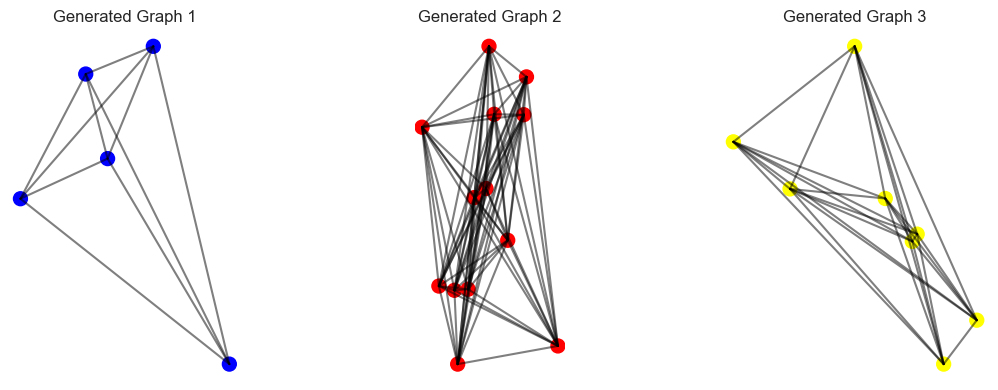

In [93]:

# First identify cluster centers
centers, labels = identify_cluster_centers(model, val_loader, device)

# Generate different graph types
circle_graphs = generate_circle_graph(model, centers, num_samples=3, device=device)
#grid_graphs = generate_grid_graph(model, centers, num_samples=3, device=device)
#star_graphs = generate_star_graph(model, centers, num_samples=3, device=device)
#tree_graphs = generate_tree_graph(model, centers, num_samples=3, device=device)

# Visualize
visualize_generated_graphs(circle_graphs)
#visualize_generated_graphs(grid_graphs)
#visualize_generated_graphs(star_graphs)
#visualize_generated_graphs(tree_graphs)
